<a href="https://colab.research.google.com/github/Thavr/ProjetoFinalGrupo2/blob/main/Projeto_Final_Grupo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto: Classificação de Subprefeituras de SP com Clustering**
---

### _Dados obtidos em_: [ObservaSampa](https://observasampa.prefeitura.sp.gov.br/index.php?page=indicadores)

### _Integrantes do grupo_:

* Felipe Bulgareli de Faria
* Gustavo Katsuo Tsutsui
* Thales Vieira Rodrigues



## **ORGANIZAÇÃO DO PROJETO**
---

Divisão de tarefas:
- Felipe:
  -   
- Gustavo:
  -   
- Thales:
  -





## **INTRODUÇÃO**

---

* Objetivo: Agrupar distritos de São Paulo segundo indicadores socioeconômicos (renda, educação, saúde etc.)

* Motivação: Investigar padrões ocultos de desigualdade e desenvolver um mapa interativo de perfis regionais.

* Tipo de problema: Clustering (não supervisionado)

## **IMPORTAÇÃO DE BIBLIOTECAS**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## **COLETA E TRATAMENTO DOS DADOS**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pasta_principal = '/content/drive/MyDrive/Projeto_Final_Grupo2/Indicadores'

dataframes = {}

# Percorrer pastas e arquivos
for root, dirs, files in os.walk(pasta_principal):
    for file in files:
        if file.endswith('.csv'):
            caminho_arquivo = os.path.join(root, file)
            # Ler o CSV
            df = pd.read_csv(caminho_arquivo, sep=';', decimal=',')
            # Renomear as colunas de anos para string
            # Como as colunas dos anos estão na forma numérica
            colunas_anos = [col for col in df.columns if col.isdigit()]
            rename_map = {col: str(col) for col in colunas_anos}
            df.rename(columns=rename_map, inplace=True)
            # Guardar no dicionário com nome base do arquivo
            nome_base = os.path.splitext(file)[0]
            dataframes[nome_base] = df
            print(f'O arquivo {file} foi carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.')


O arquivo  familias_em_extrema pobreza.csv foi carregado com 129 linhas e 16 colunas.
O arquivo empregos_formais_municipio_total.csv foi carregado com 129 linhas e 20 colunas.
O arquivo ocorrencias_deslizamento.csv foi carregado com 129 linhas e 15 colunas.
O arquivo ocorrencias_alagamento.csv foi carregado com 129 linhas e 15 colunas.
O arquivo moradias_setores_risco_geologico_alto.csv foi carregado com 33 linhas e 9 colunas.
O arquivo violencia_criancas_adolescentes_notificados.csv foi carregado com 129 linhas e 12 colunas.
O arquivo violencia_pessoas_idosas_notificados.csv foi carregado com 129 linhas e 12 colunas.
O arquivo tempo_espera_exames_prioritarios.csv foi carregado com 33 linhas e 16 colunas.
O arquivo taxa_mortalidade_infantil.csv foi carregado com 129 linhas e 22 colunas.
O arquivo proporcao_gestantes_adolescentes.csv foi carregado com 129 linhas e 22 colunas.
O arquivo numero_ubs.csv foi carregado com 33 linhas e 17 colunas.
O arquivo idade_media_ao_morrer.csv foi carre

Alguns arquivos foram carregados com 129 linhas, uma vez que, apesar de termos selecionados no ObservaSampa que pretendíamos ter apenas os dados de subprefeituras, os dados dos distritos vieram junto. Nesse sentido, é necessária uma etapa de exclusão desses dados.

In [ ]:
for nome, df in dataframes.items():
    if 'nivel_regional' in df.columns:
        # Filtrar só linhas com Subprefeitura
        df_filtrado = df[df['nivel_regional'] == 'Subprefeitura'].copy()
        print(f"{nome}: {df.shape[0]} linhas -> {df_filtrado.shape[0]} linhas após filtro subprefeitura")
        dataframes[nome] = df_filtrado.reset_index(drop=True)

 familias_em_extrema pobreza: 129 linhas -> 32 linhas após filtro subprefeitura
empregos_formais_municipio_total: 129 linhas -> 32 linhas após filtro subprefeitura
ocorrencias_deslizamento: 129 linhas -> 32 linhas após filtro subprefeitura
ocorrencias_alagamento: 129 linhas -> 32 linhas após filtro subprefeitura
moradias_setores_risco_geologico_alto: 33 linhas -> 32 linhas após filtro subprefeitura
violencia_criancas_adolescentes_notificados: 129 linhas -> 32 linhas após filtro subprefeitura
violencia_pessoas_idosas_notificados: 129 linhas -> 32 linhas após filtro subprefeitura
tempo_espera_exames_prioritarios: 33 linhas -> 32 linhas após filtro subprefeitura
taxa_mortalidade_infantil: 129 linhas -> 32 linhas após filtro subprefeitura
proporcao_gestantes_adolescentes: 129 linhas -> 32 linhas após filtro subprefeitura
numero_ubs: 33 linhas -> 32 linhas após filtro subprefeitura
idade_media_ao_morrer: 129 linhas -> 32 linhas após filtro subprefeitura
domicilios_sem_esgoto_percentual: 129

Após o filtro, foram selecionados apenas os dados relacionados às subprefeituras.

In [ ]:
dfs_long = []

for nome, df in dataframes.items():
    # Identificar colunas de anos
    colunas_ano = [col for col in df.columns if col.isdigit()]  # pega só as colunas que são anos

    # Fazer melt para formato longo
    df_long = df.melt(id_vars=['região', 'nivel_regional', 'indicador'], value_vars=colunas_ano,
                      var_name='ano', value_name='valor')

    # Adicionar coluna com o nome do indicador
    df_long['nome_indicador'] = nome

    dfs_long.append(df_long)

# Concatenar tudo em um dataframe só
df_concatenado = pd.concat(dfs_long, ignore_index=True)

df_concatenado


região nivel_regional  \
0     Vila Maria-Vila Guilherme  Subprefeitura   
1                   Parelheiros  Subprefeitura   
2                  Vila Mariana  Subprefeitura   
3                 Vila Prudente  Subprefeitura   
4                         Penha  Subprefeitura   
...                         ...            ...   
7323            Jaçanã-Tremembé  Subprefeitura   
7324                  Sapopemba  Subprefeitura   
7325                         Sé  Subprefeitura   
7326                 São Mateus  Subprefeitura   
7327                 São Miguel  Subprefeitura   

                                              indicador   ano    valor  \
0     01.01.01 Quantidade de famílias em situação de...  2013   1115.0   
1     01.01.01 Quantidade de famílias em situação de...  2013   9351.0   
2     01.01.01 Quantidade de famílias em situação de...  2013   6968.0   
3     01.01.01 Quantidade de famílias em situação de...  2013   8852.0   
4     01.01.01 Quantidade de famílias em situação de...  2013  11834.0   
...                                                 ...   ...      ...   
7323  01.03.01 Quantidade de famílias que recebem re...  2024  21210.0   
7324  01.03.01 Quantidade de famílias que recebem re...  2024  22360.0   
7325  01.03.01 Quantidade de famílias que recebem re...  2024  28382.0   
7326  01.03.01 Quantidade de famílias que recebem re...  2024  39637.0   
7327  01.03.01 Quantidade de famílias que recebem re...  2024  33866.0   

                    nome_indicador  
0      familias_em_extrema pobreza  
1      familias_em_extrema pobreza  
2      familias_em_extrema pobreza  
3      familias_em_extrema pobreza  
4      familias_em_extrema pobreza  
...                            ...  
7323  familias_transferencia_renda  
7324  familias_transferencia_renda  
7325  familias_transferencia_renda  
7326  familias_transferencia_renda  
7327  familias_transferencia_renda  

[7328 rows x 6 columns]

In [ ]:
# Checando para valores ausentes
valores_ausentes = df_concatenado.isna().any()
print("Valores ausentes no dataframe:\n", valores_ausentes)

# Checando para valores = 0
df_concatenado[(df_concatenado == 0).any(axis=1)]


Valores ausentes no dataframe:
 região            False
nivel_regional    False
indicador         False
ano               False
valor             False
nome_indicador    False
dtype: bool


região nivel_regional  \
896                Penha  Subprefeitura   
898            Pinheiros  Subprefeitura   
901          Santo Amaro  Subprefeitura   
903           São Miguel  Subprefeitura   
910         Vila Mariana  Subprefeitura   
...                  ...            ...   
6843       Cidade Ademar  Subprefeitura   
6844   Cidade Tiradentes  Subprefeitura   
6845  Ermelino Matarazzo  Subprefeitura   
6846               Penha  Subprefeitura   
6847           Pinheiros  Subprefeitura   

                                              indicador   ano  valor  \
896   11.05.02 Número de ocorrências atendidas – des...  2013    0.0   
898   11.05.02 Número de ocorrências atendidas – des...  2013    0.0   
901   11.05.02 Número de ocorrências atendidas – des...  2013    0.0   
903   11.05.02 Número de ocorrências atendidas – des...  2013    0.0   
910   11.05.02 Número de ocorrências atendidas – des...  2013    0.0   
...                                                 ...   ...    ...   
6843              01.01.02 População em situação de rua  2011    0.0   
6844              01.01.02 População em situação de rua  2011    0.0   
6845              01.01.02 População em situação de rua  2011    0.0   
6846              01.01.02 População em situação de rua  2011    0.0   
6847              01.01.02 População em situação de rua  2011    0.0   

                nome_indicador  
896   ocorrencias_deslizamento  
898   ocorrencias_deslizamento  
901   ocorrencias_deslizamento  
903   ocorrencias_deslizamento  
910   ocorrencias_deslizamento  
...                        ...  
6843    pop_em_situacao_de_rua  
6844    pop_em_situacao_de_rua  
6845    pop_em_situacao_de_rua  
6846    pop_em_situacao_de_rua  
6847    pop_em_situacao_de_rua  

[162 rows x 6 columns]

## **ANÁLISE EXPLORATÓRIA**

Pares de Indicadores com Correlação > 0.85:

domicilios_sem_agua_percentual x cobertura_vegetal_per_capita_m2hab -> Correlação: 0.99
domicilios_sem_esgoto_percentual x cobertura_vegetal_per_capita_m2hab -> Correlação: 0.87
domicilios_sem_esgoto_percentual x domicilios_sem_agua_percentual -> Correlação: 0.91
estabelecimentos_formais_total x empregos_formais_municipio_total -> Correlação: 0.97
familias_transferencia_renda x  familias_em_extrema pobreza -> Correlação: 0.99
pop_em_situacao_de_rua x livros_servicos_leitura_1000hab -> Correlação: 0.88
proporcao_gestantes_adolescentes x idade_media_ao_morrer -> Correlação: 0.96
taxa_mortalidade_infantil x idade_media_ao_morrer -> Correlação: 0.87
taxa_mortalidade_infantil x proporcao_gestantes_adolescentes -> Correlação: 0.92
violencia_pessoas_idosas_notificados x violencia_criancas_adolescentes_notificados -> Correlação: 0.94
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 16 columns):
 #   Column   

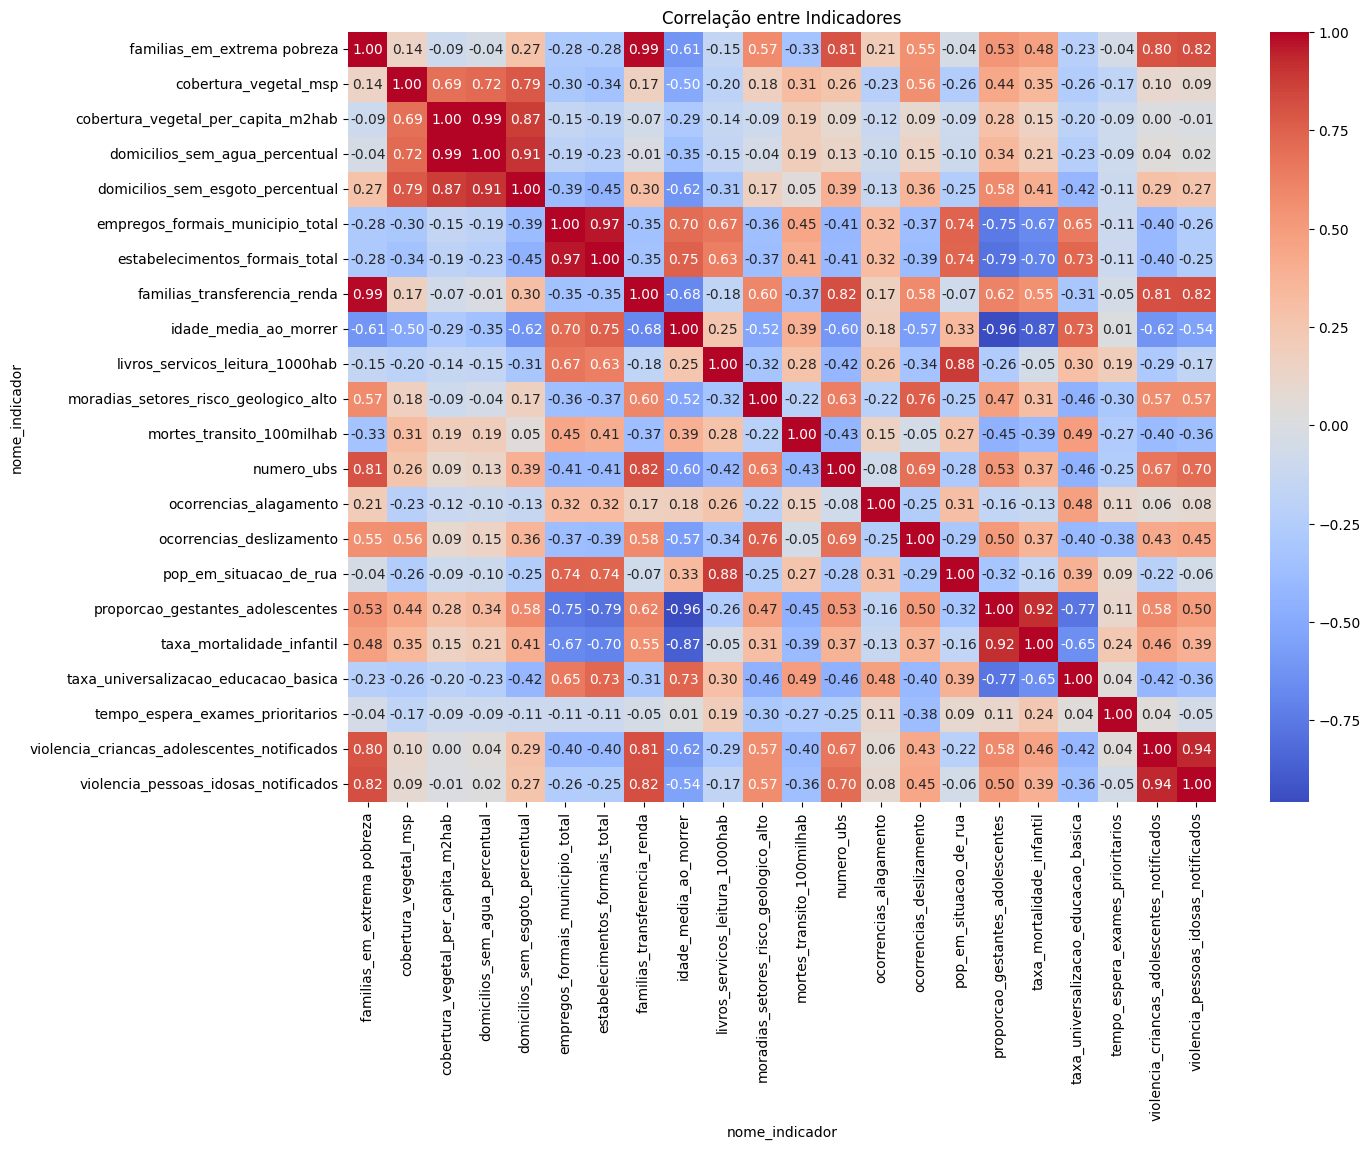

In [ ]:
# Pivotar a tabela: regiões como índice e indicadores como colunas
df_pivot = df_concatenado.pivot_table(
    index='região',
    columns='nome_indicador',
    values='valor'
)

# Calcular a matriz de correlação
corr_matrix = df_pivot.corr().abs()

# Pegar somente a parte superior da matriz (triângulo superior)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar os pares de indicadores com correlação maior que 0.85
pares_colineares = [(coluna, idx, upper.loc[idx, coluna])
                    for coluna in upper.columns
                    for idx in upper.index
                    if upper.loc[idx, coluna] > 0.85]

# Exibir os pares com colinearidade alta
print("Pares de Indicadores com Correlação > 0.85:\n")
for par in pares_colineares:
    print(f"{par[0]} x {par[1]} -> Correlação: {par[2]:.2f}")

#Estatísticas Básicas:
# Visualização geral
df.info()
df.describe(include='all')
df.isnull().sum()
df.duplicated().sum()

#Calculando Coeficiente de Variaçao para testar Variação dos Dados
coef_variação= df_pivot.std()/ df_pivot.mean()
coef_variação.sort_values(ascending=False)
print(coef_variação)


#Correlação entre indicadores
plt.figure(figsize=(14, 10))
sns.heatmap(df_pivot.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre Indicadores")
plt.show()



## **REGRESSÃO**

A fim de prever o comportamento dos indicadores ao longo do tempo, inicialmente, fez-se necessário observar a evolução temporal média ao longo do período.

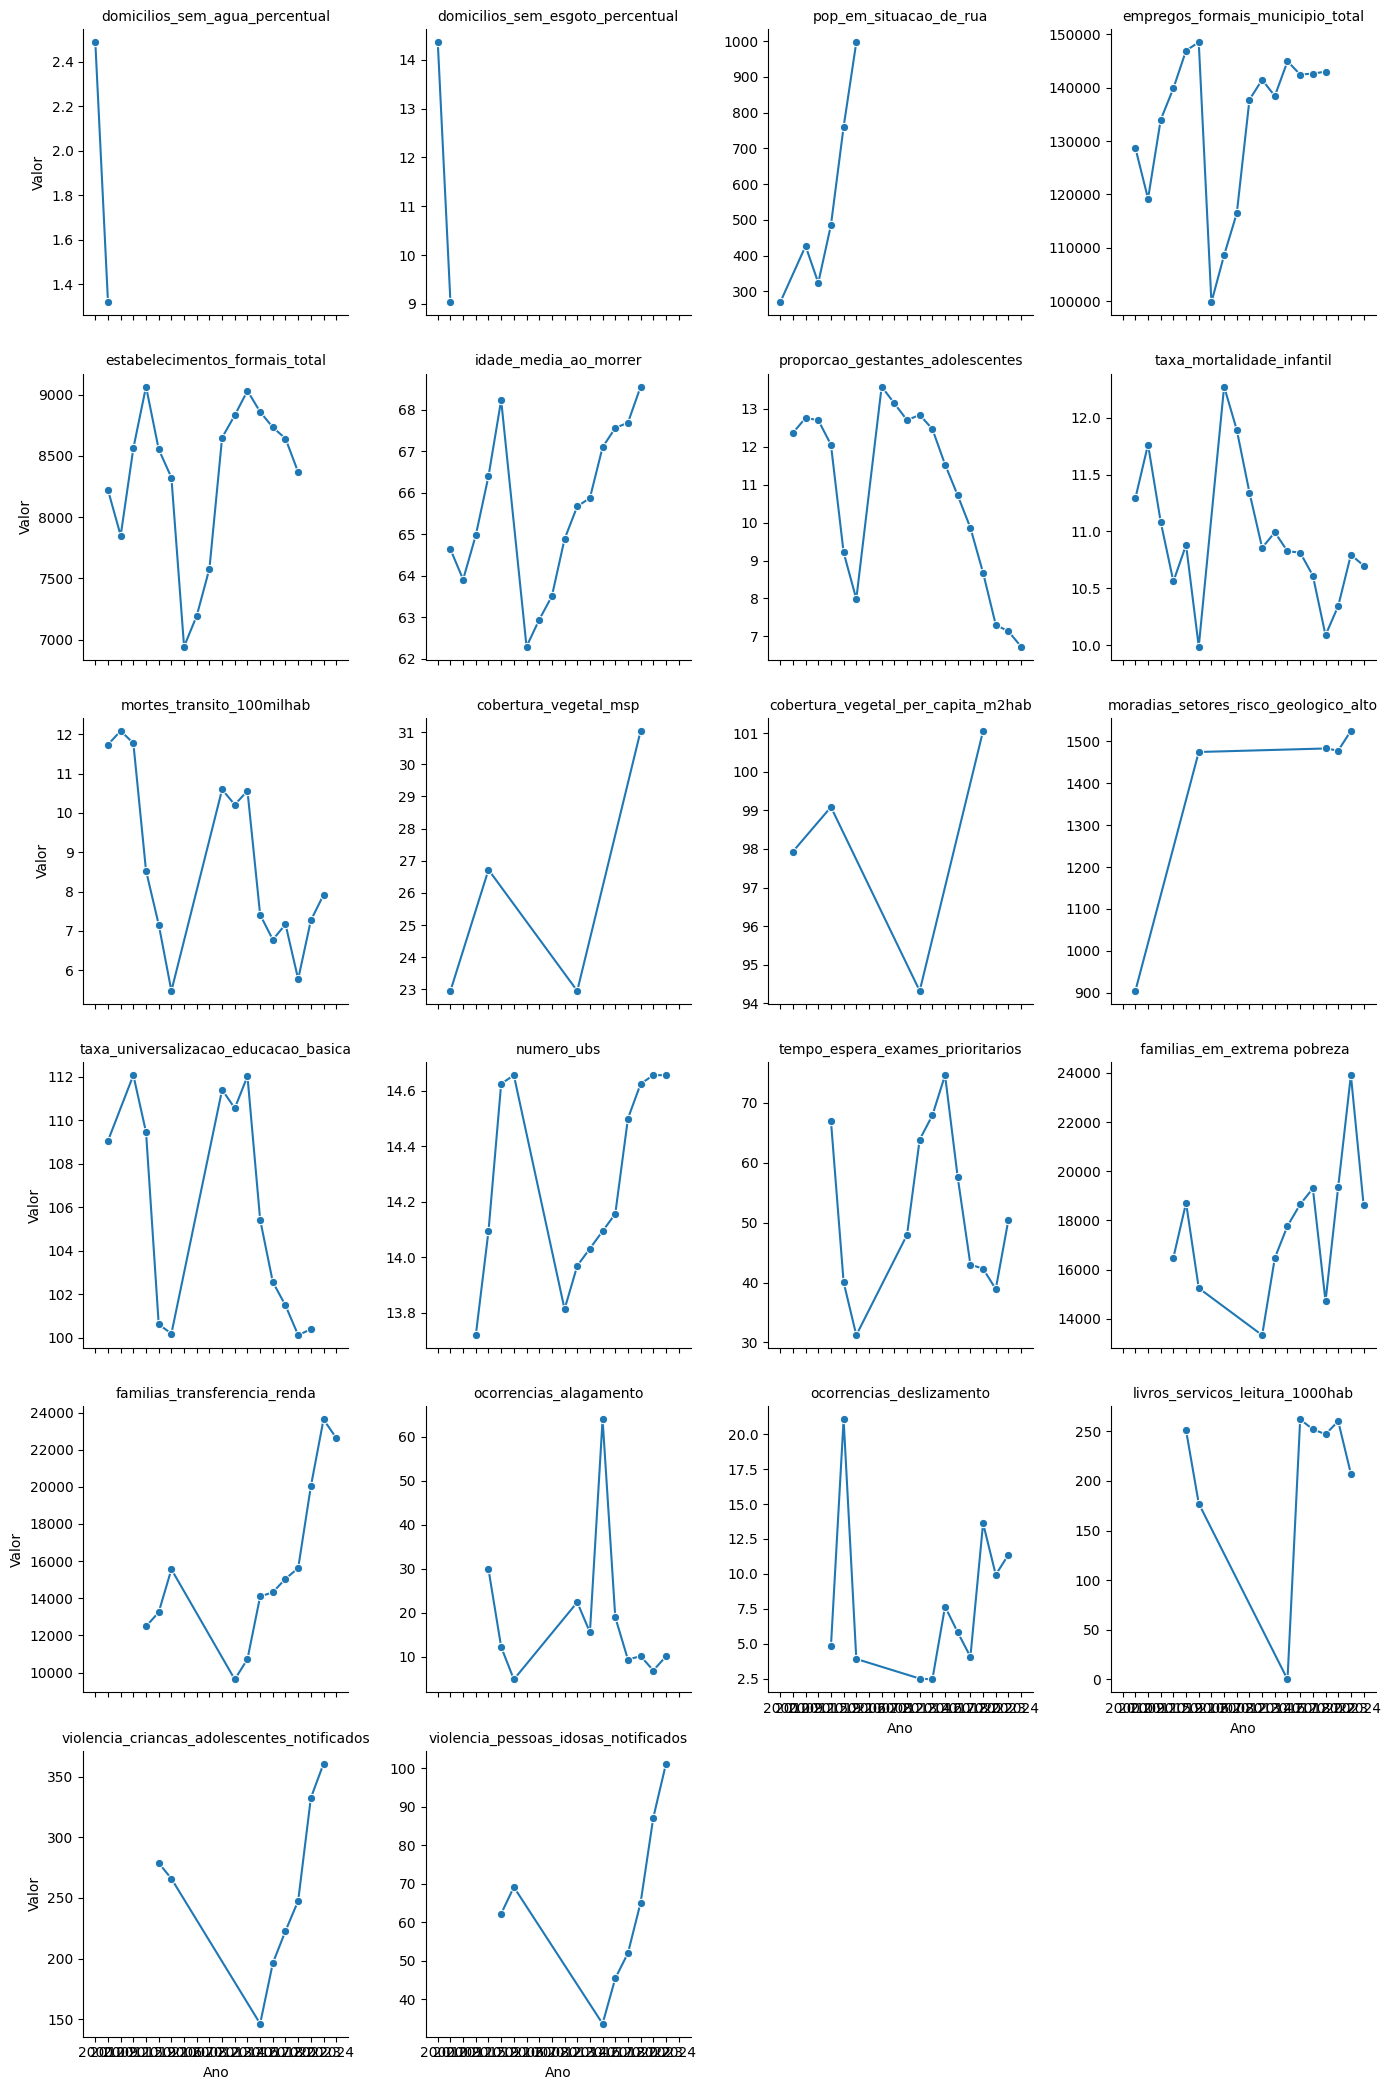

In [ ]:
# Calcular média dos indicadores por ano (toda a cidade)
df_media_geral = df_concatenado.groupby(['ano', 'nome_indicador'])['valor'].mean().reset_index()

# Plotar evolução temporal
g = sns.FacetGrid(df_media_geral, col='nome_indicador', col_wrap=4, height=3.5, sharey=False)
g.map_dataframe(sns.lineplot, x='ano', y='valor', marker='o', )
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Ano", "Valor")
plt.show()


Em seguida, é construído o pipeline de previsão por regressão linear

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

def prever_indicador(df, indicador, anos_futuros=5):
    df_ind = df[df['nome_indicador'] == indicador].copy()
    df_ind['ano'] = pd.to_numeric(df_ind['ano'])
    X = df_ind['ano'].values.reshape(-1, 1)
    y = df_ind['valor'].values

    modelo = LinearRegression()
    modelo.fit(X, y)

    # Projeção
    anos_proj = np.arange(X.min(), X.max() + anos_futuros + 1).reshape(-1, 1)
    previsoes = modelo.predict(anos_proj)

    # Cálculo das métricas
    previsoes_observadas = modelo.predict(X)
    r_squared = r2_score(y, previsoes_observadas)
    mae = mean_absolute_error(y, previsoes_observadas)
    mape = mean_absolute_percentage_error(y, previsoes_observadas)

    # Plot
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df_ind['ano'], y=df_ind['valor'], label='Observado', color='blue')
    sns.lineplot(x=anos_proj.flatten(), y=previsoes, label='Projeção', color='red', linestyle='--')
    plt.title(f"Projeção: {indicador} (R² = {r_squared:.2f})")
    plt.xlabel("Ano")
    plt.ylabel("Valor")
    plt.show()

    return r_squared, mae, mape

Agora, são plotados os gráficos de regressão apontando a diferença entre a previsão do modelo e o que foi observado, assim como métricas de desempenho

Previsão para o indicador: domicilios_sem_agua_percentual


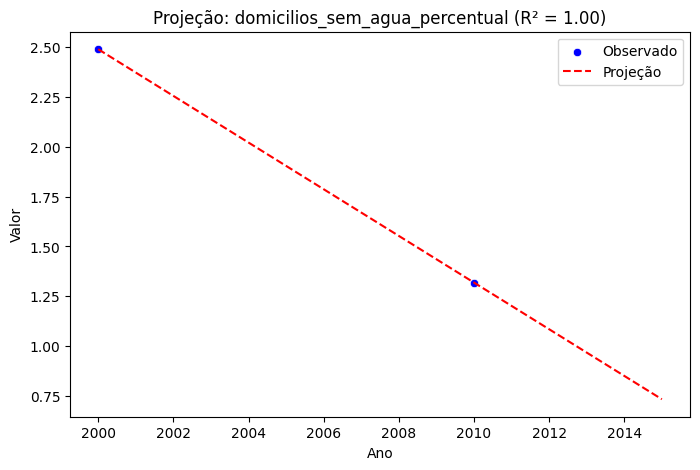

Previsão para o indicador: domicilios_sem_esgoto_percentual


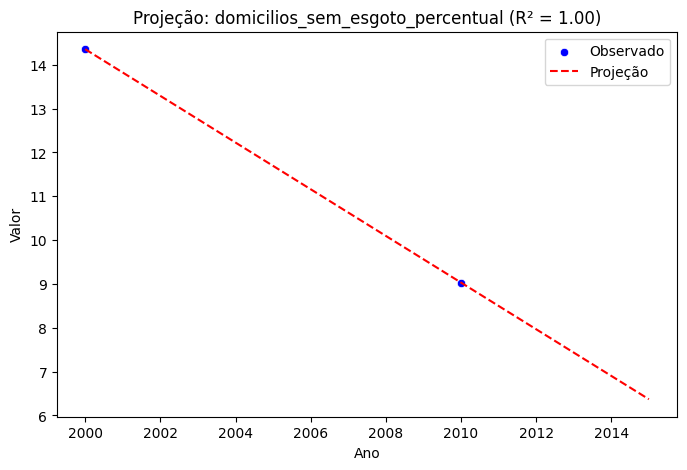

Previsão para o indicador: pop_em_situacao_de_rua


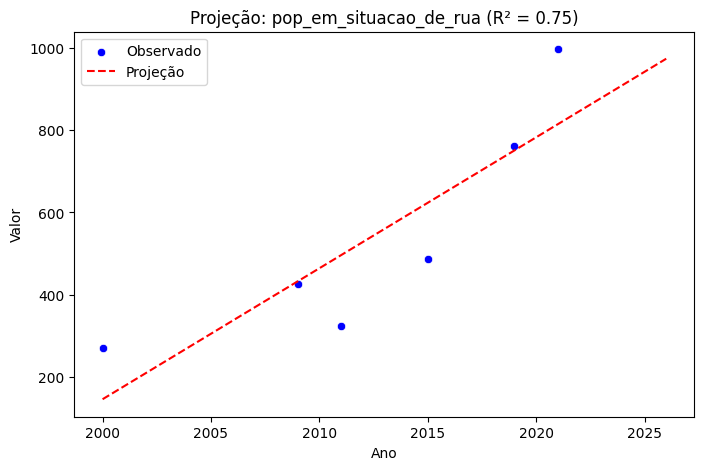

Previsão para o indicador: empregos_formais_municipio_total


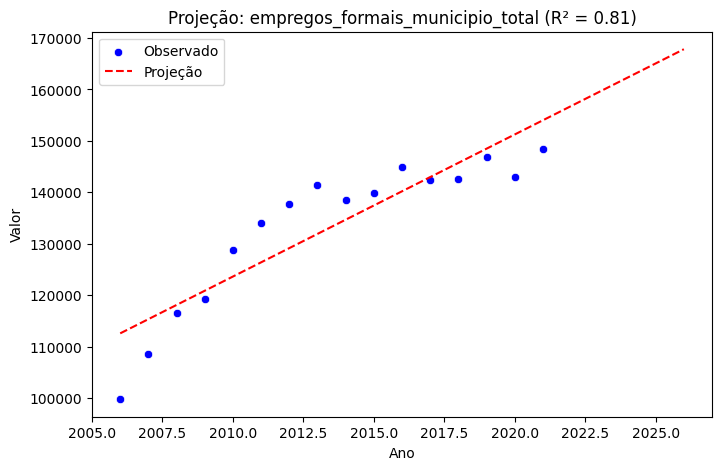

Previsão para o indicador: estabelecimentos_formais_total


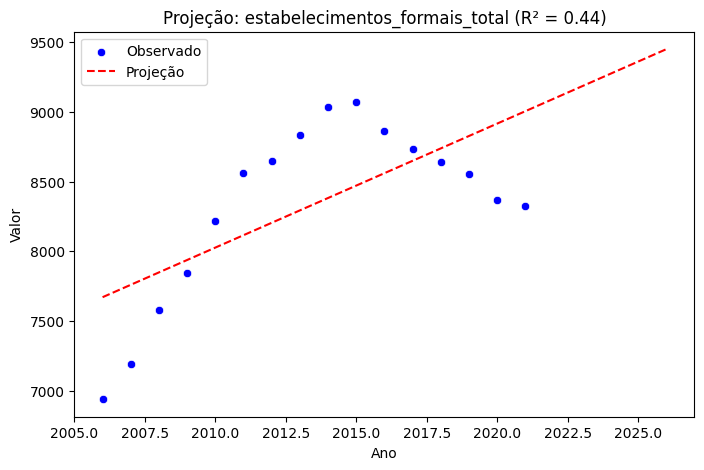

Previsão para o indicador: idade_media_ao_morrer


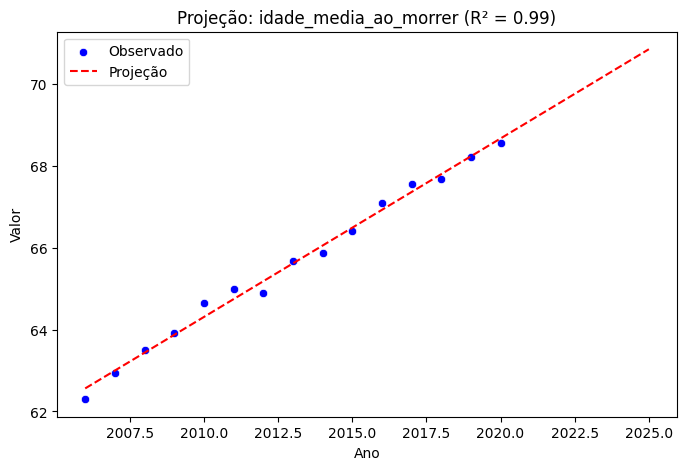

Previsão para o indicador: proporcao_gestantes_adolescentes


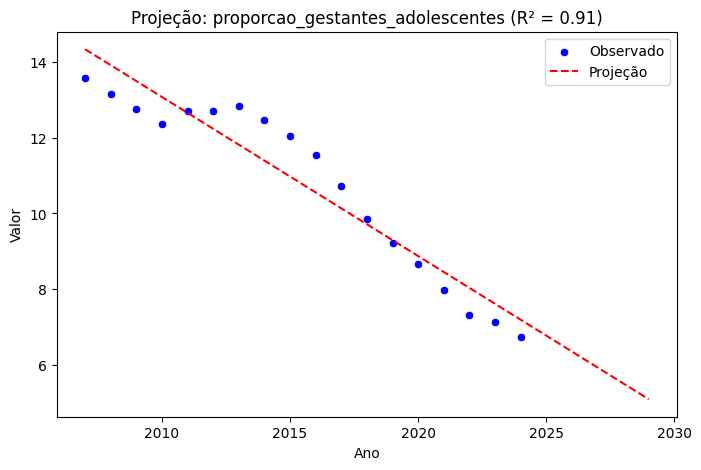

Previsão para o indicador: taxa_mortalidade_infantil


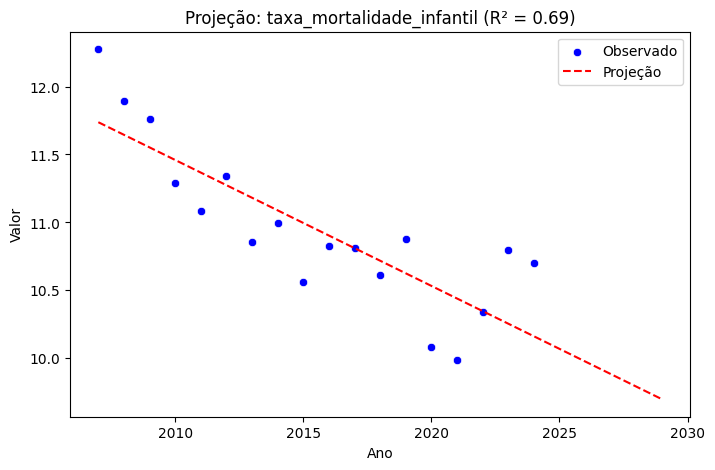

Previsão para o indicador: mortes_transito_100milhab


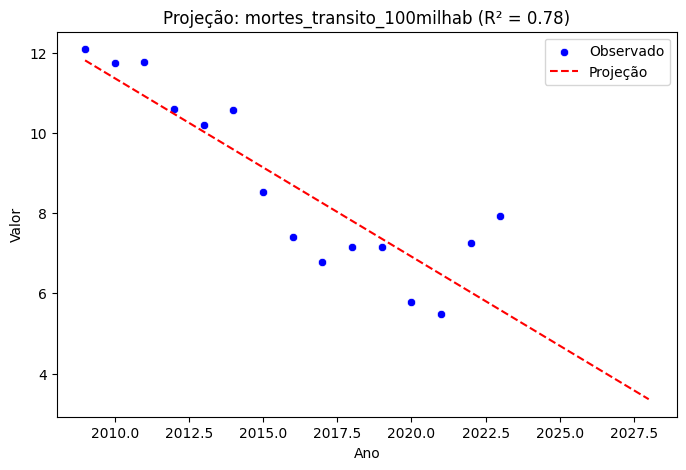

Previsão para o indicador: cobertura_vegetal_msp


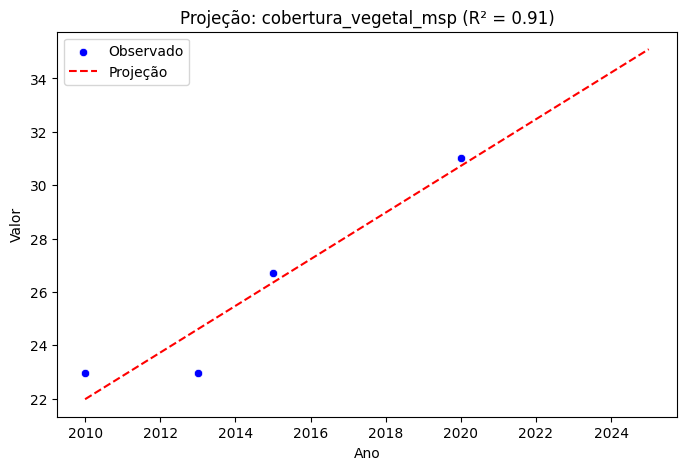

Previsão para o indicador: cobertura_vegetal_per_capita_m2hab


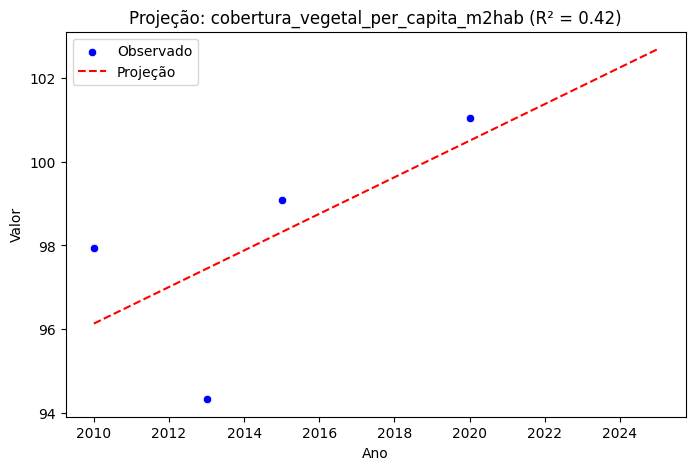

Previsão para o indicador: moradias_setores_risco_geologico_alto


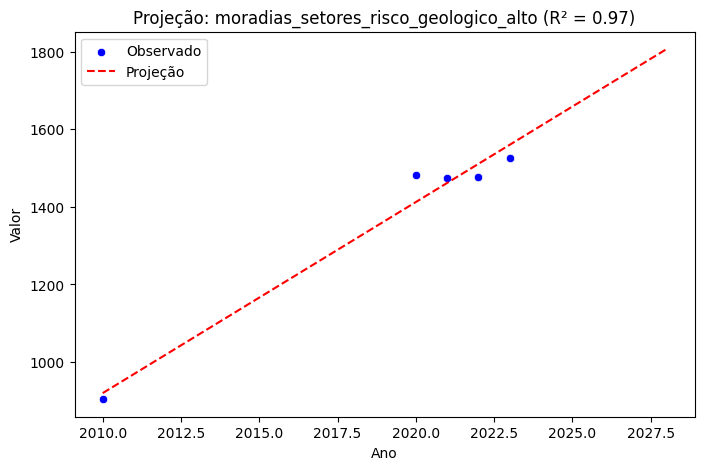

Previsão para o indicador: taxa_universalizacao_educacao_basica


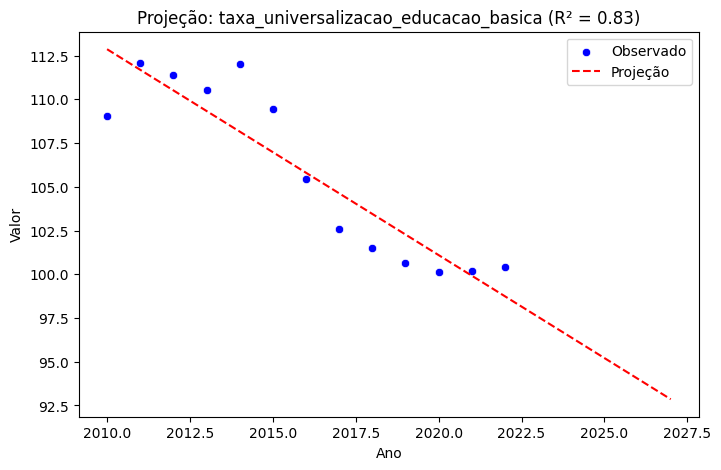

Previsão para o indicador: numero_ubs


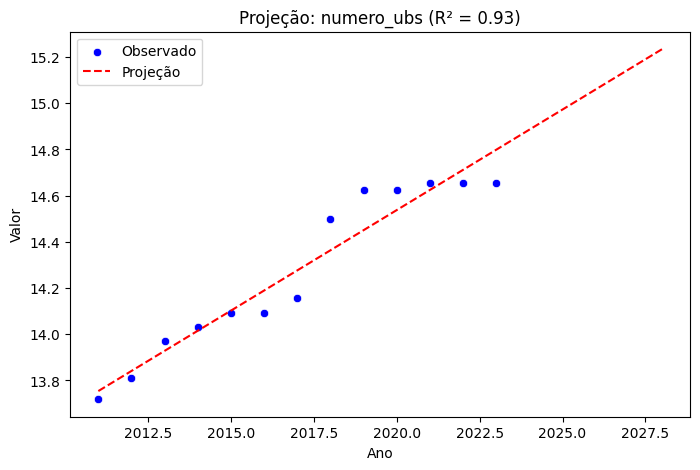

Previsão para o indicador: tempo_espera_exames_prioritarios


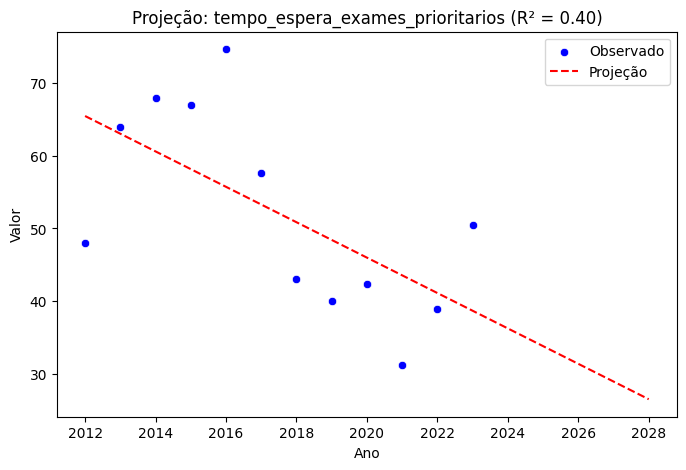

Previsão para o indicador:  familias_em_extrema pobreza


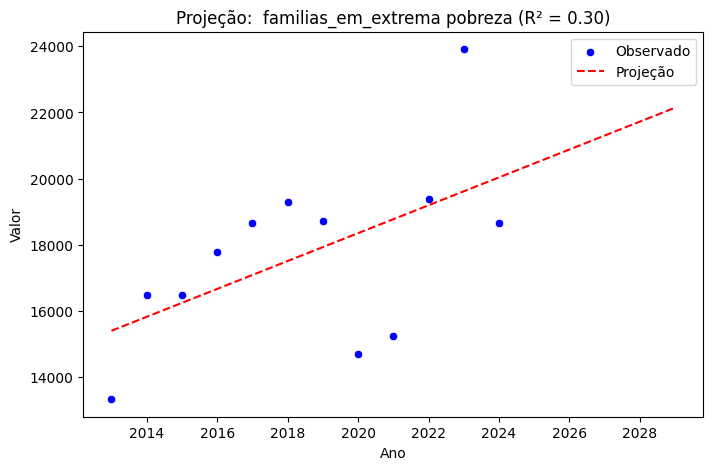

Previsão para o indicador: familias_transferencia_renda


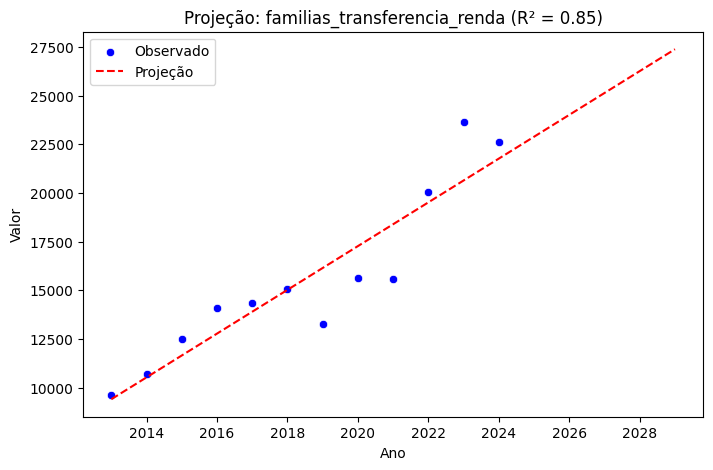

Previsão para o indicador: ocorrencias_alagamento


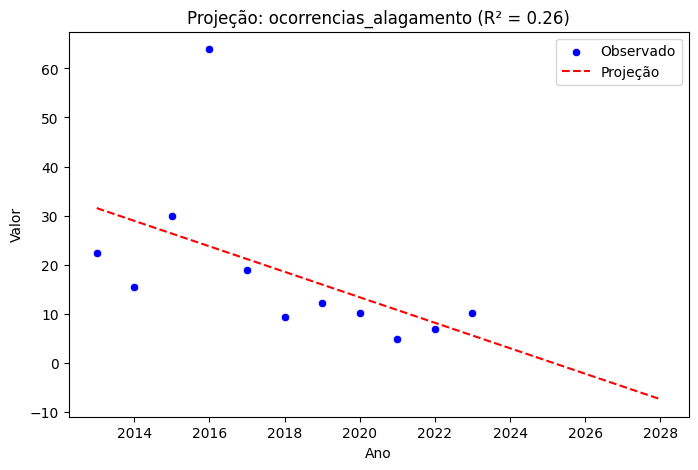

Previsão para o indicador: ocorrencias_deslizamento


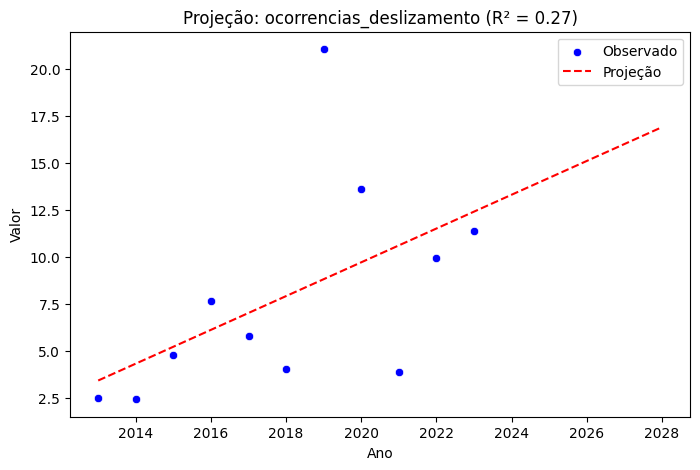

Previsão para o indicador: livros_servicos_leitura_1000hab


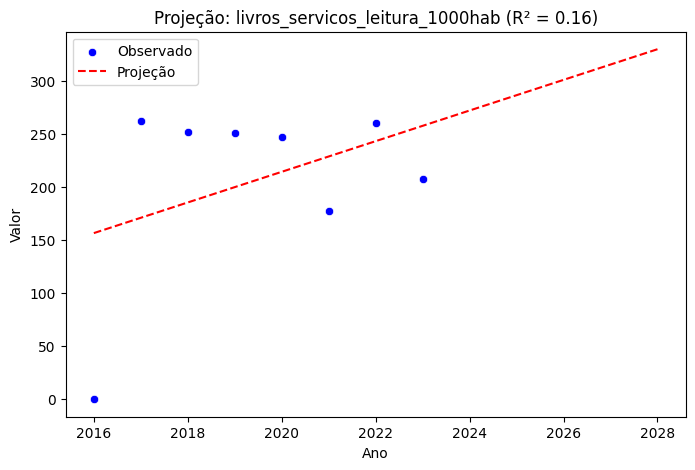

Previsão para o indicador: violencia_criancas_adolescentes_notificados


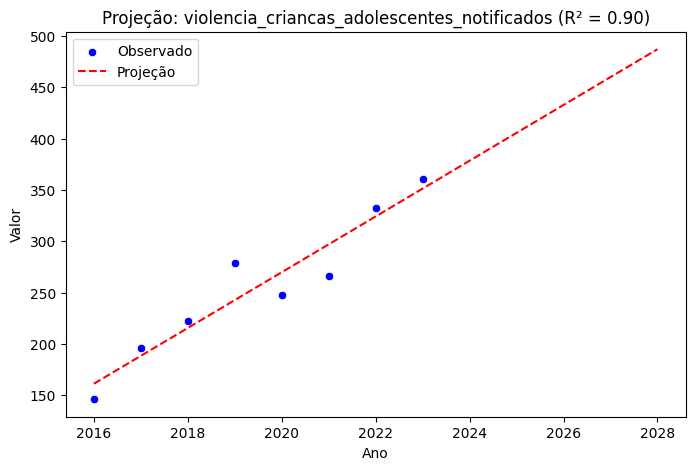

Previsão para o indicador: violencia_pessoas_idosas_notificados


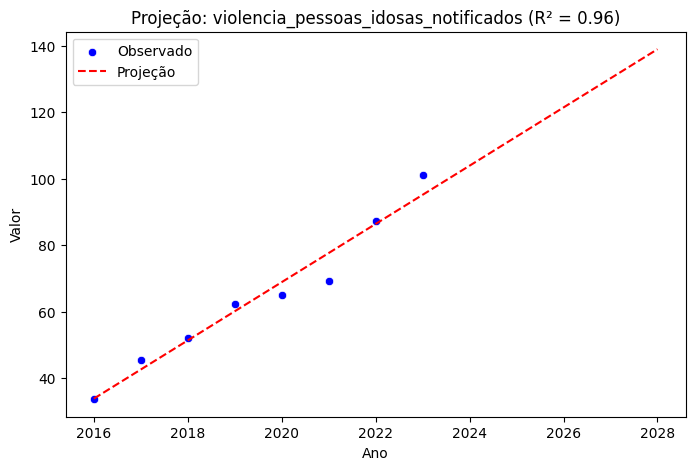


Resumo das Métricas por Indicador:
domicilios_sem_agua_percentual: R² = 1.00 | MAE = 0.00 | MAPE = 0.00
domicilios_sem_esgoto_percentual: R² = 1.00 | MAE = 0.00 | MAPE = 0.00
pop_em_situacao_de_rua: R² = 0.75 | MAE = 105.05 | MAPE = 0.25
empregos_formais_municipio_total: R² = 0.81 | MAE = 5220.42 | MAPE = 0.04
estabelecimentos_formais_total: R² = 0.44 | MAE = 406.52 | MAPE = 0.05
idade_media_ao_morrer: R² = 0.99 | MAE = 0.15 | MAPE = 0.00
proporcao_gestantes_adolescentes: R² = 0.91 | MAE = 0.60 | MAPE = 0.06
taxa_mortalidade_infantil: R² = 0.69 | MAE = 0.27 | MAPE = 0.02
mortes_transito_100milhab: R² = 0.78 | MAE = 0.85 | MAPE = 0.11
cobertura_vegetal_msp: R² = 0.91 | MAE = 0.83 | MAPE = 0.03
cobertura_vegetal_per_capita_m2hab: R² = 0.42 | MAE = 1.56 | MAPE = 0.02
moradias_setores_risco_geologico_alto: R² = 0.97 | MAE = 33.48 | MAPE = 0.02
taxa_universalizacao_educacao_basica: R² = 0.83 | MAE = 1.66 | MAPE = 0.02
numero_ubs: R² = 0.93 | MAE = 0.07 | MAPE = 0.01
tempo_espera_exames_pri

In [ ]:
r2_scores = {}
mae_scores = {}
mape_scores = {}

indicadores_unicos = df_media_geral['nome_indicador'].unique()
subprefeituras_unicas = df_concatenado['região'].unique()

for indicador in indicadores_unicos:
    print(f"Previsão para o indicador: {indicador}")
    r2, mae, mape = prever_indicador(df_media_geral, indicador, anos_futuros=5)
    r2_scores[indicador] = r2
    mae_scores[indicador] = mae
    mape_scores[indicador] = mape

# Resumo final das métricas
print("\nResumo das Métricas por Indicador:")
for indicador in indicadores_unicos:
    print(f"{indicador}: R² = {r2_scores[indicador]:.2f} | MAE = {mae_scores[indicador]:.2f} | MAPE = {mape_scores[indicador]:.2f}")



Também é possível realizar previsões para cada subprefeitura por indicador:

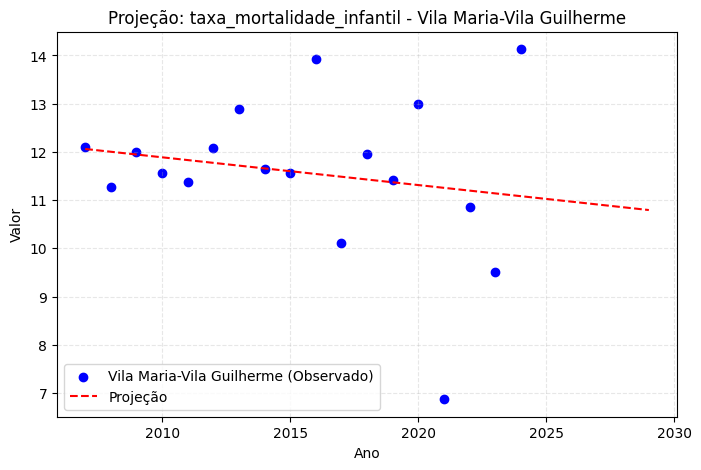

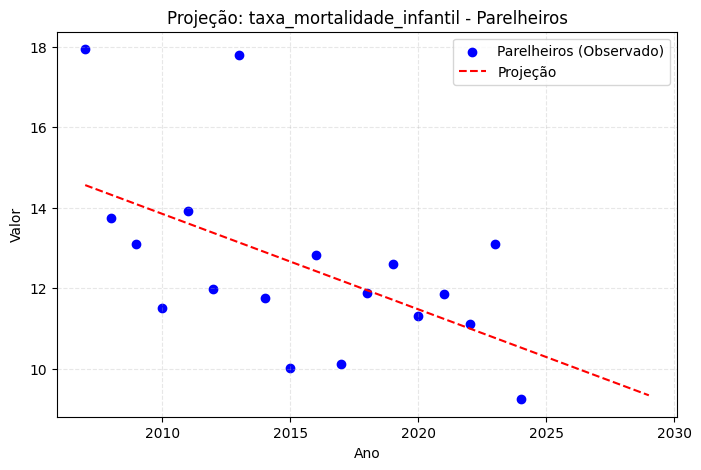

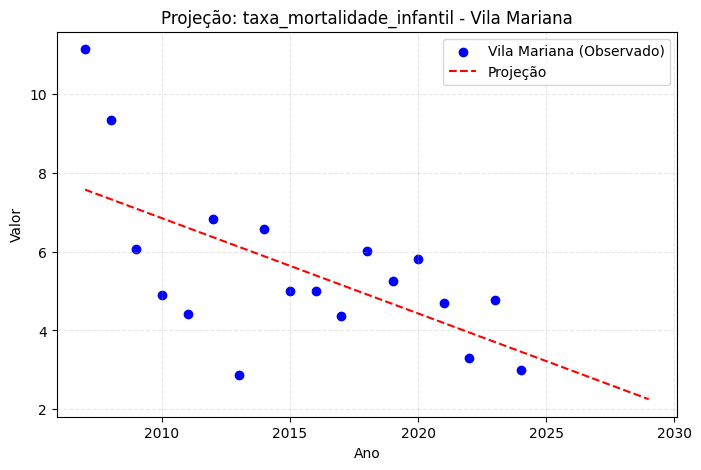

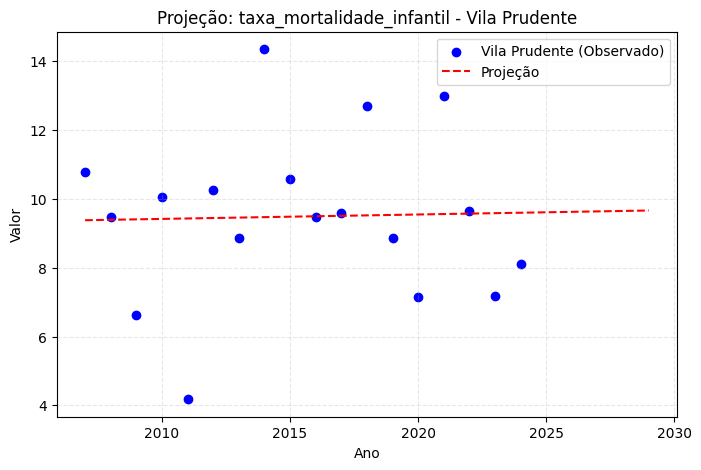

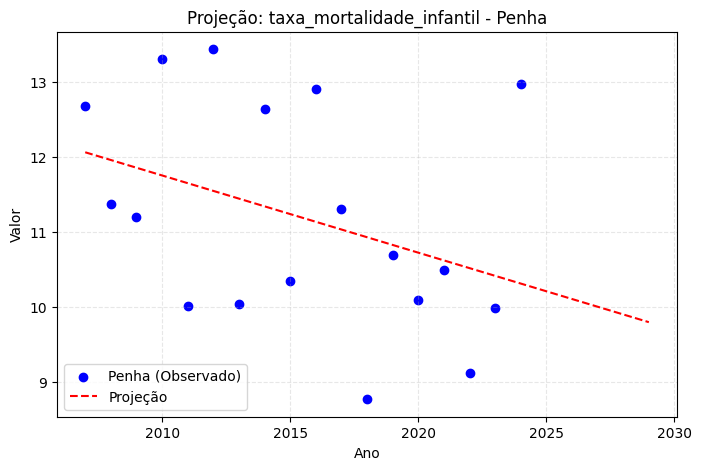

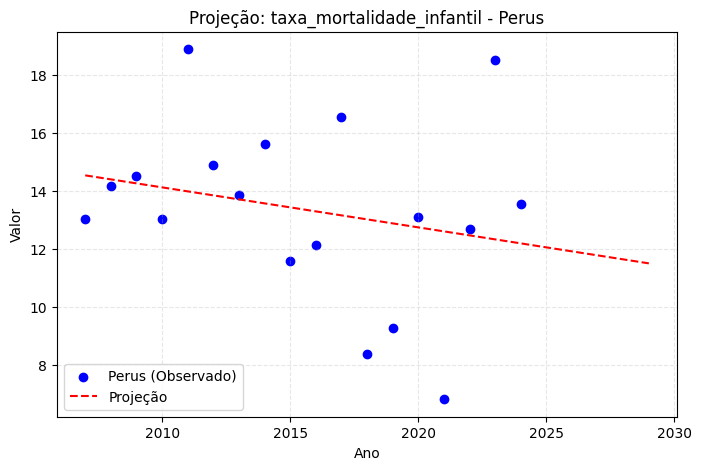

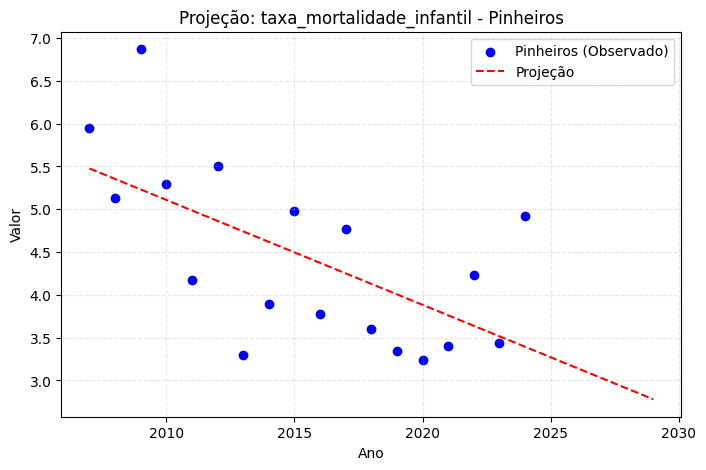

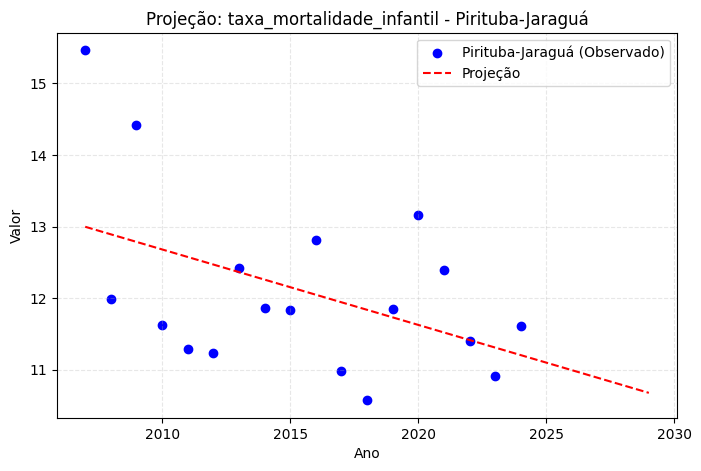

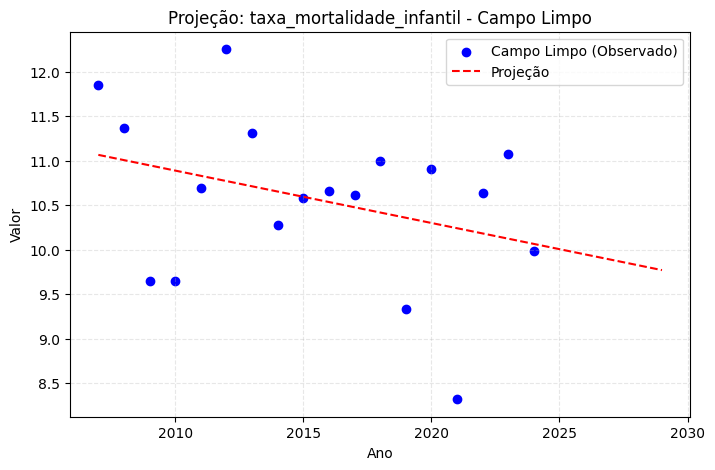

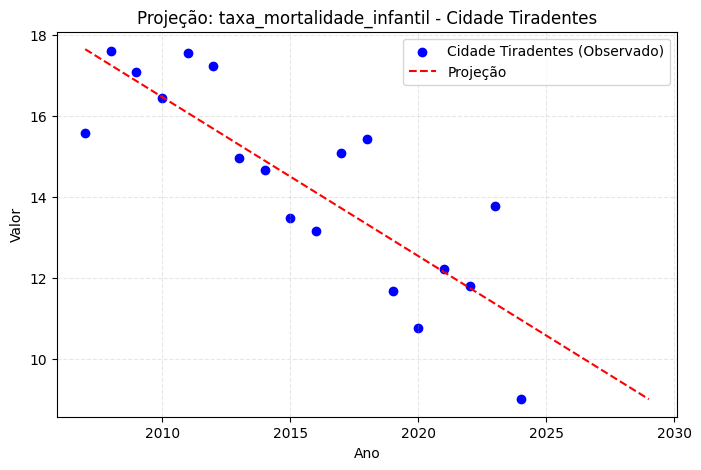

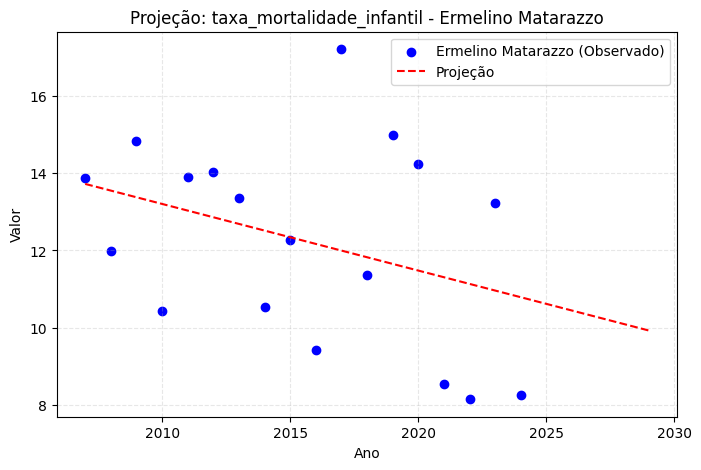

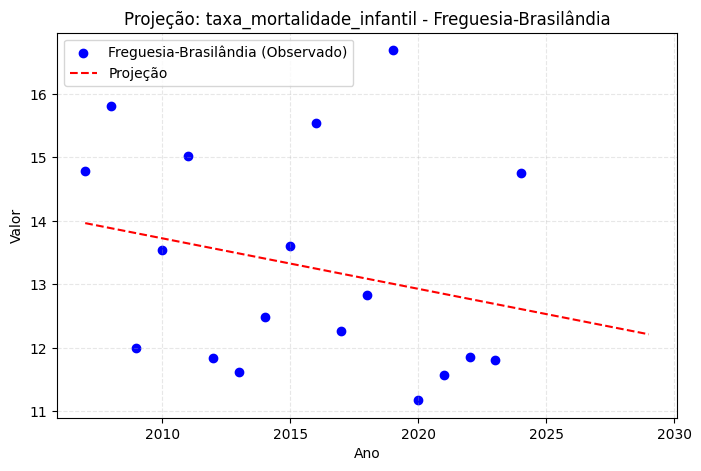

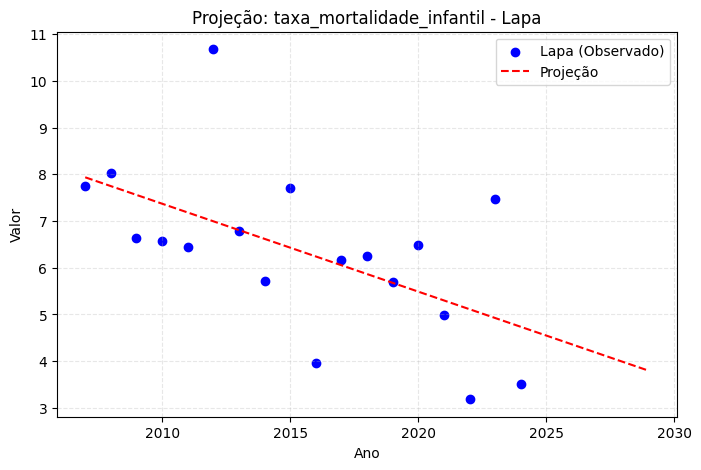

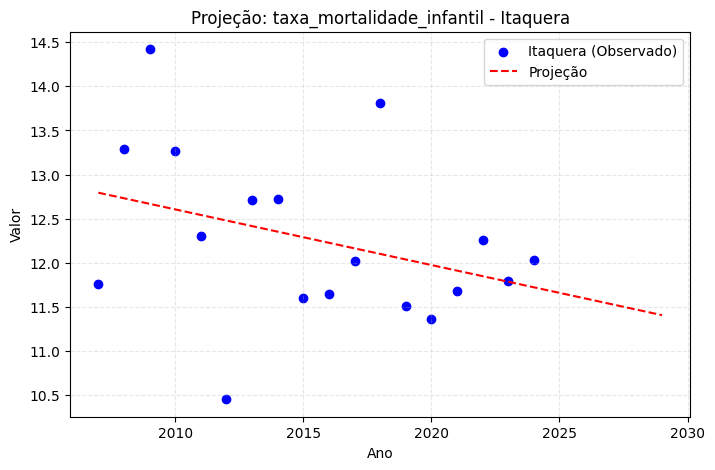

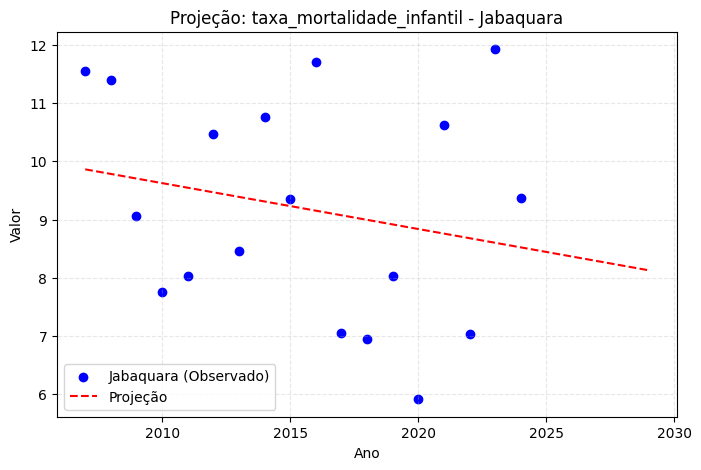

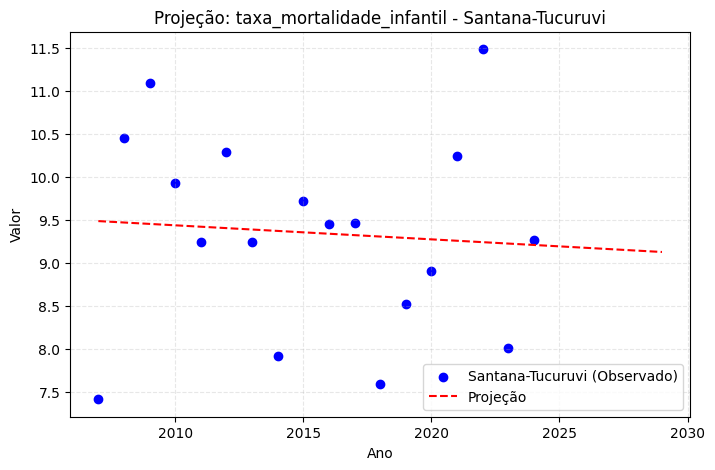

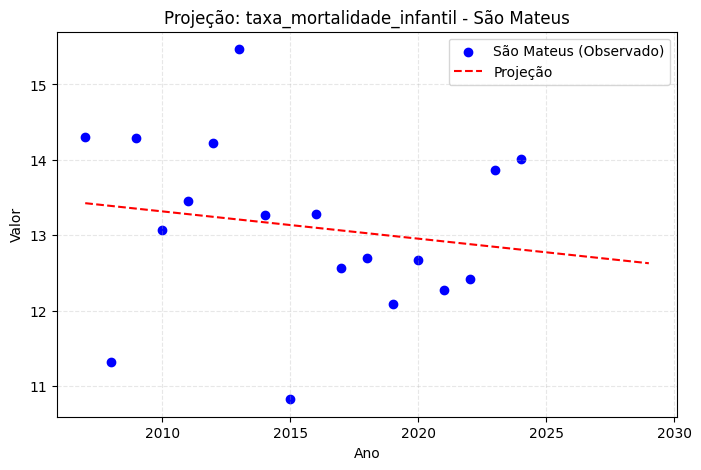

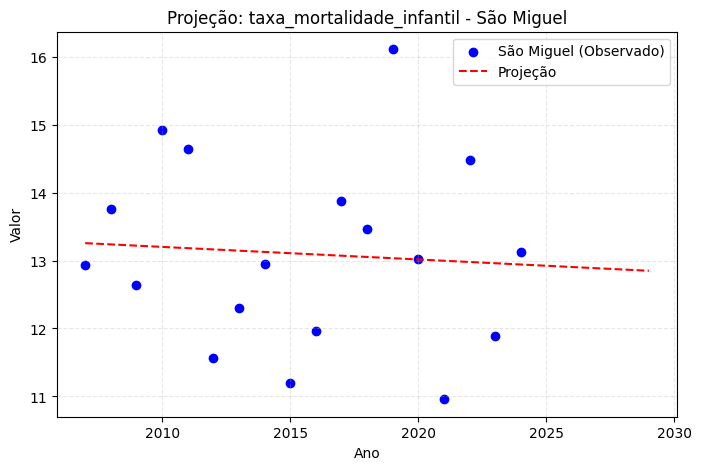

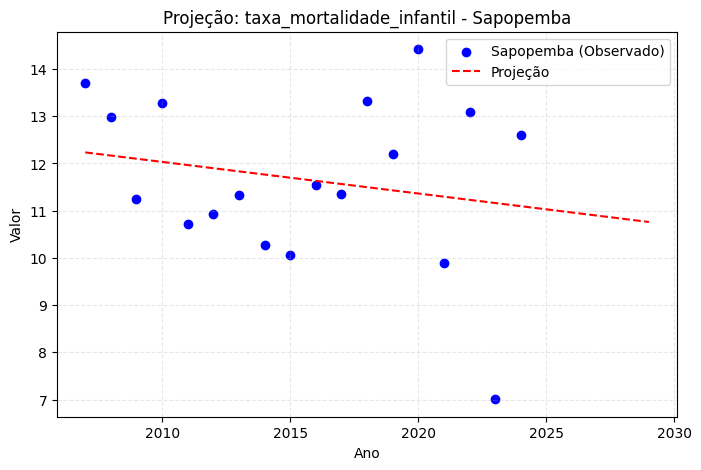

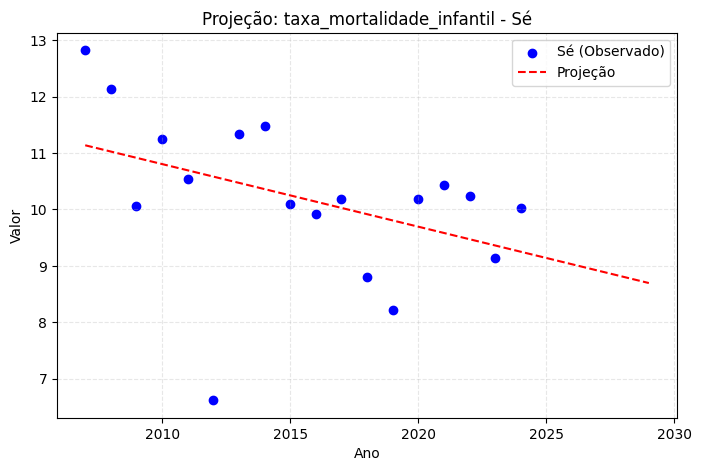

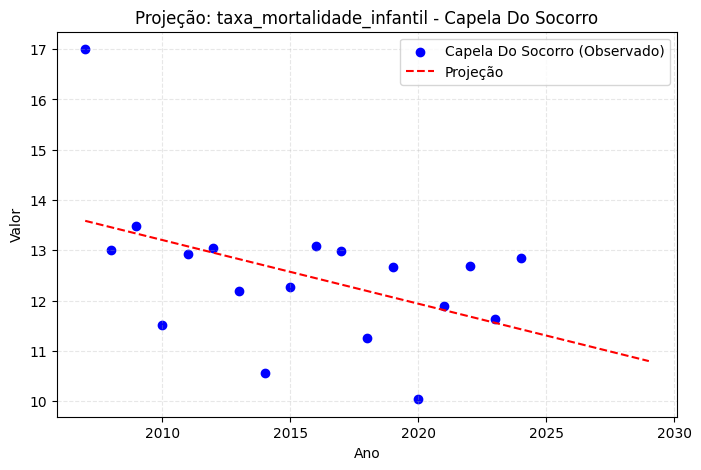

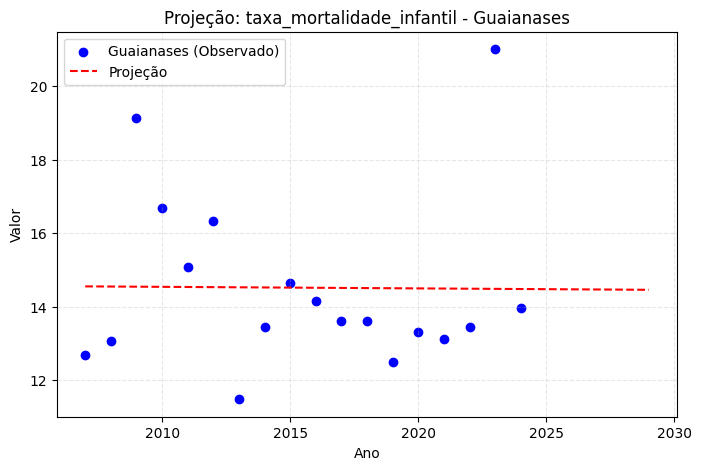

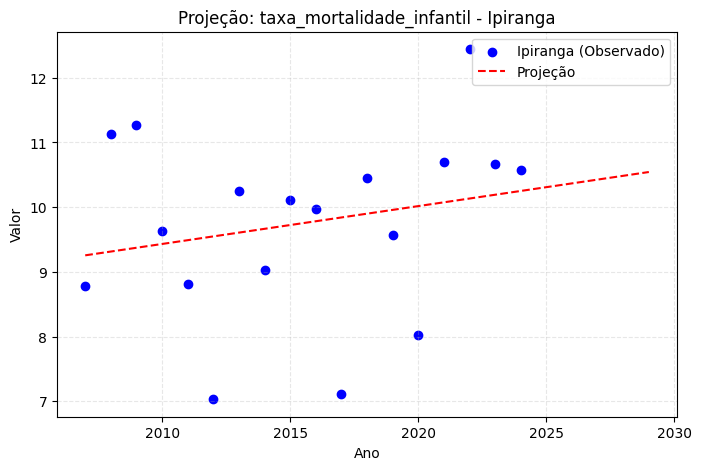

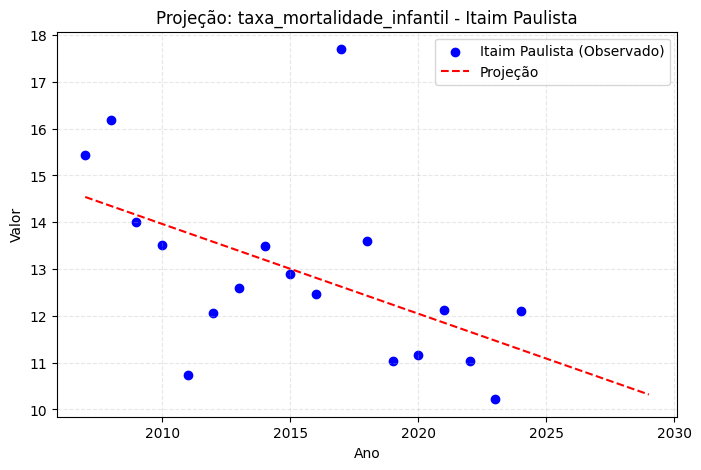

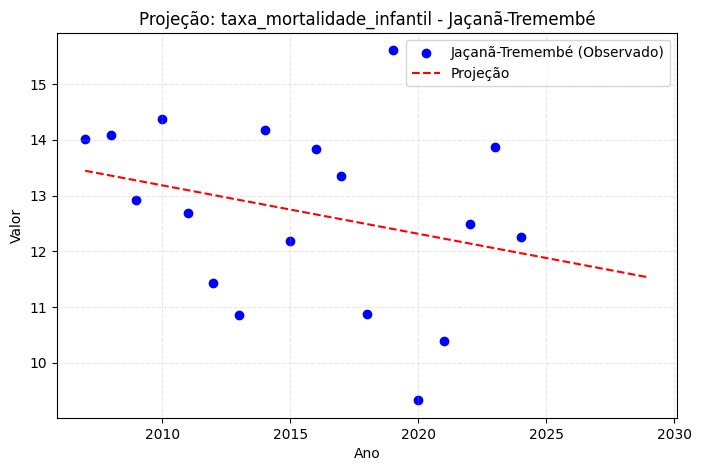

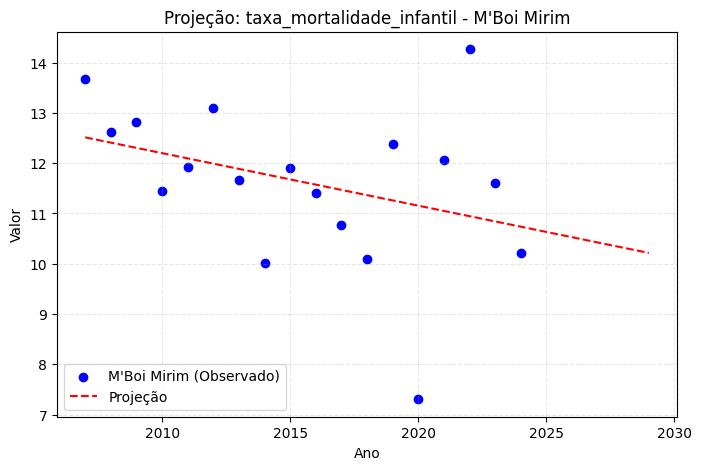

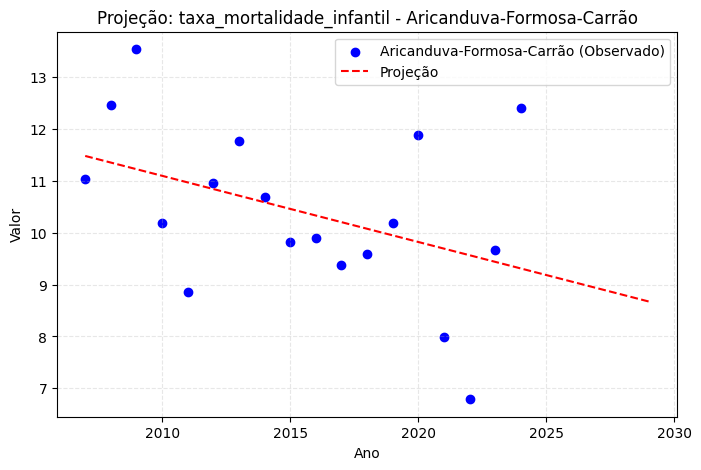

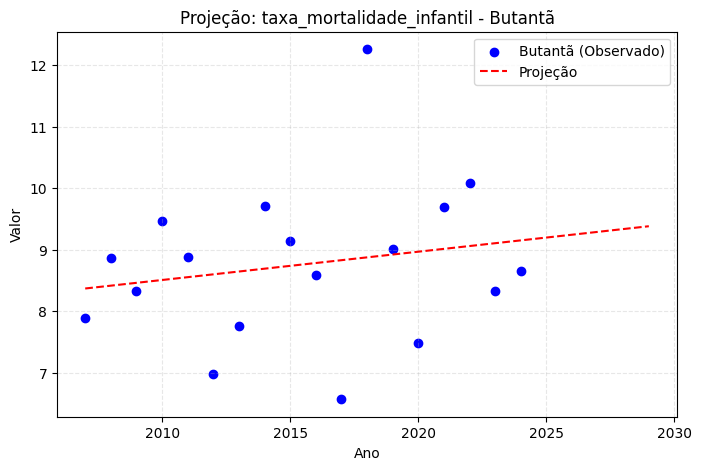

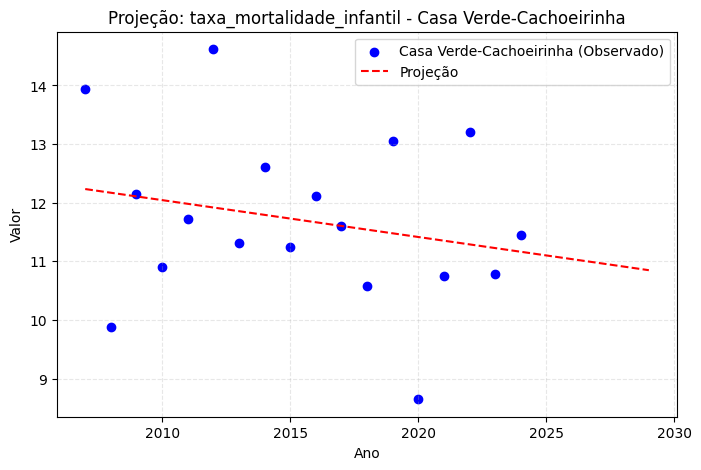

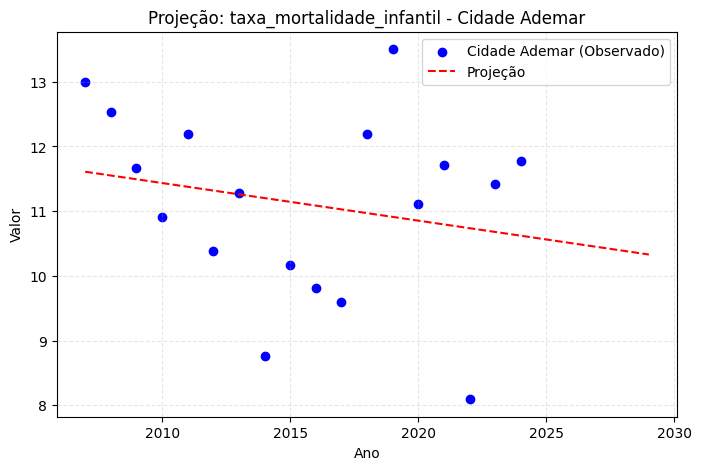

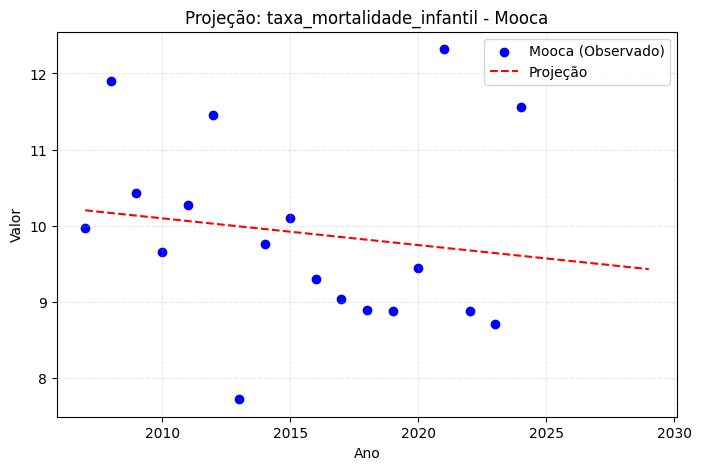

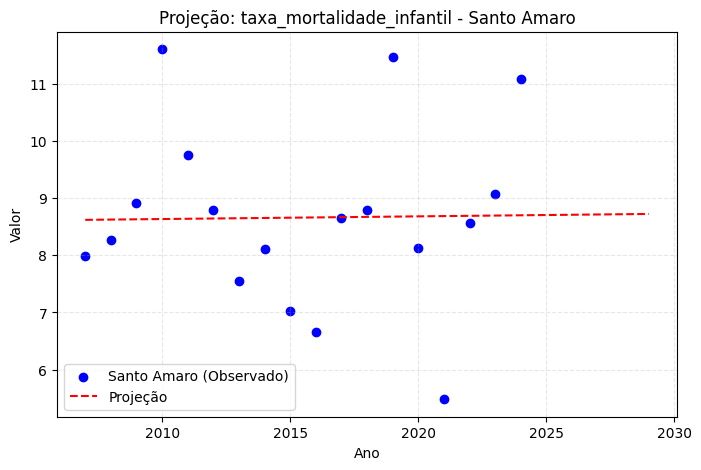

In [ ]:
def prever_indicador_por_subprefeitura(df, indicador, anos_futuros=5):
    subprefeituras = df['região'].unique()

    for sub in subprefeituras:
        df_sub = df[(df['nome_indicador'] == indicador) & (df['região'] == sub)].copy()

        if len(df_sub) < 3:  # Ignorar subprefeituras com poucos dados
            continue

        df_sub['ano'] = pd.to_numeric(df_sub['ano'])
        X = df_sub['ano'].values.reshape(-1, 1)
        y = df_sub['valor'].values

        modelo = LinearRegression()
        modelo.fit(X, y)

        anos_proj = np.arange(X.min(), X.max() + anos_futuros + 1).reshape(-1, 1)
        previsoes = modelo.predict(anos_proj)

        plt.figure(figsize=(8,5))

        # Plot
        plt.scatter(df_sub['ano'], df_sub['valor'], color='blue', label=f'{sub} (Observado)')
        plt.plot(anos_proj.flatten(), previsoes, color='red', linestyle='--', label='Projeção')

        plt.title(f"Projeção: {indicador} - {sub}")
        plt.xlabel("Ano")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.show()

prever_indicador_por_subprefeitura(df_concatenado, 'taxa_mortalidade_infantil', anos_futuros=5) # Indicador teste


Por fim, é criado um pipeline integrado com todas as etapas.

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cria o PDF com os gráficos
pdf_filename = 'projecoes_subprefeituras.pdf'
pdf = PdfPages(pdf_filename)

# Função com pdf como argumento
def prever_indicador_subprefeitura(df, indicador, subprefeitura, pdf, anos_futuros=5):
    df_sub = df[(df['nome_indicador'] == indicador) & (df['região'] == subprefeitura)].copy()
    if len(df_sub) < 3:
        return None  # Ignorar se tiver poucos dados

    df_sub['ano'] = pd.to_numeric(df_sub['ano'])
    X = df_sub['ano'].values.reshape(-1, 1)
    y = df_sub['valor'].values

    modelo = LinearRegression()
    modelo.fit(X, y)

    anos_proj = np.arange(X.min(), X.max() + anos_futuros + 1).reshape(-1, 1)
    previsoes = modelo.predict(anos_proj)

    previsoes_observadas = modelo.predict(X)
    r_squared = r2_score(y, previsoes_observadas)
    mae = mean_absolute_error(y, previsoes_observadas)
    mape = mean_absolute_percentage_error(y, previsoes_observadas) * 100  # %

    # Plot
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df_sub['ano'], y=df_sub['valor'], label='Observado', color='blue')
    sns.lineplot(x=anos_proj.flatten(), y=previsoes, label='Projeção', color='red', linestyle='--')
    plt.title(f"Projeção: {indicador} - {subprefeitura}")
    plt.xlabel("Ano")
    plt.ylabel("Valor")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Salvar a página no PDF
    pdf.savefig()
    plt.close()

    # Retornar as métricas para DataFrame
    return {
        'Indicador': indicador,
        'Subprefeitura': subprefeitura,
        'R²': r_squared,
        'MAE': mae,
        'MAPE (%)': mape
    }

# Definir as listas únicas
indicadores_unicos = df_concatenado['nome_indicador'].unique()
subprefeituras_unicas = df_concatenado['região'].unique()

# Loop principal
resultados = []
for indicador in indicadores_unicos:
    for sub in subprefeituras_unicas:
        resultado = prever_indicador_subprefeitura(df_concatenado, indicador, sub, pdf, anos_futuros=5)
        if resultado:
            resultados.append(resultado)

# Fechar e salvar o PDF
pdf.close()

# Exportar os resultados
df_resultados = pd.DataFrame(resultados)
df_resultados.to_excel('Resumo_Metricas_Projecao_Subprefeituras.xlsx', index=False)

# Fazer download dos arquivos
from google.colab import files
files.download('projecoes_subprefeituras.pdf')
files.download('Resumo_Metricas_Projecao_Subprefeituras.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Resumo das métricas
print(df_resultados.describe())

               R²           MAE      MAPE (%)
count  640.000000    640.000000  6.400000e+02
mean     0.498491    757.070006  1.059087e+18
std      0.329604   3833.491778  4.309166e+18
min      0.000003      0.000000  0.000000e+00
25%      0.176261      1.143535  6.379111e+00
50%      0.522369      8.297619  1.284634e+01
75%      0.819167     91.419221  3.458264e+01
max      1.000000  61281.324265  4.664247e+19


## **CLUSTERING**

Silhouette Score: 0.17
k = 2 -> Silhouette Score: 0.250
k = 3 -> Silhouette Score: 0.179
k = 4 -> Silhouette Score: 0.174
k = 5 -> Silhouette Score: 0.162
k = 6 -> Silhouette Score: 0.041
k = 7 -> Silhouette Score: 0.106
k = 8 -> Silhouette Score: 0.164
k = 9 -> Silhouette Score: 0.152
k = 10 -> Silhouette Score: 0.163
k = 11 -> Silhouette Score: 0.151
k = 12 -> Silhouette Score: 0.144


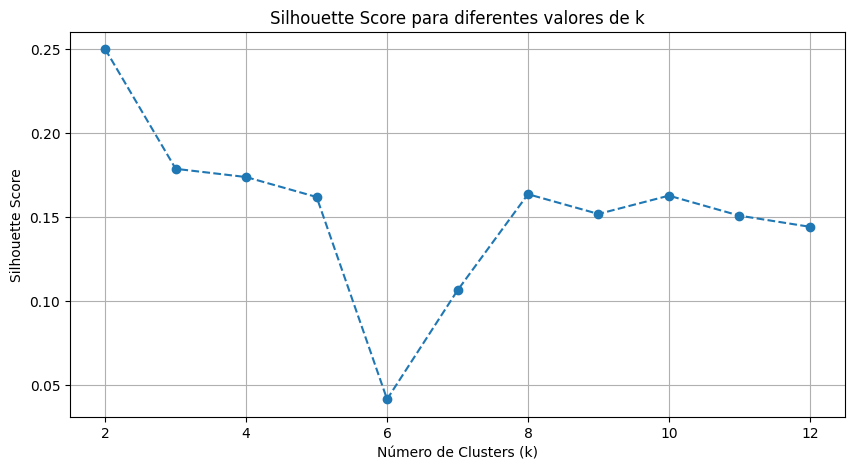

k = 2 -> Silhouette Score: 0.230
k = 3 -> Silhouette Score: 0.172
k = 4 -> Silhouette Score: 0.193
k = 5 -> Silhouette Score: 0.146
k = 6 -> Silhouette Score: 0.221
k = 7 -> Silhouette Score: 0.165
k = 8 -> Silhouette Score: 0.192
k = 9 -> Silhouette Score: 0.219
k = 10 -> Silhouette Score: 0.166
k = 11 -> Silhouette Score: 0.147
k = 12 -> Silhouette Score: 0.133


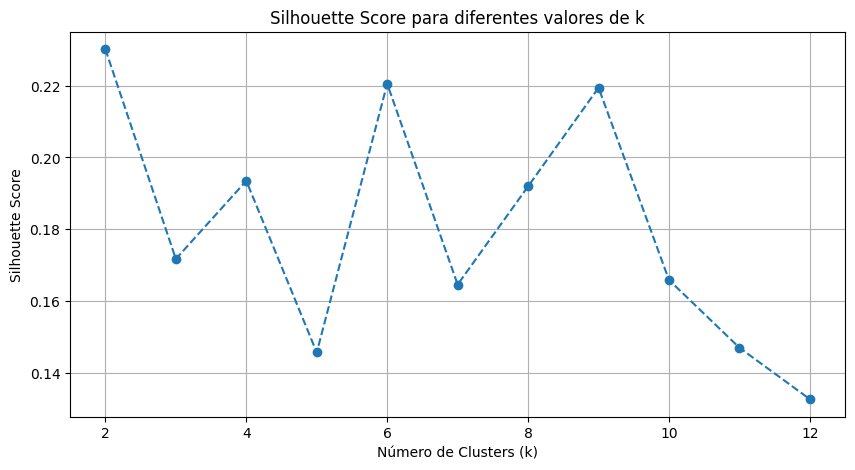

nome_indicador   familias_em_extrema pobreza  cobertura_vegetal_msp  \
cluster                                                               
0                                   0.616149               0.505170   
1                                  -0.698302              -0.572526   

nome_indicador  cobertura_vegetal_per_capita_m2hab  \
cluster                                              
0                                         0.201196   
1                                        -0.228022   

nome_indicador  estabelecimentos_formais_total  idade_media_ao_morrer  \
cluster                                                                 
0                                    -0.542249              -0.780964   
1                                     0.614549               0.885093   

nome_indicador  moradias_setores_risco_geologico_alto  \
cluster                                                 
0                                            0.521558   
1                                 

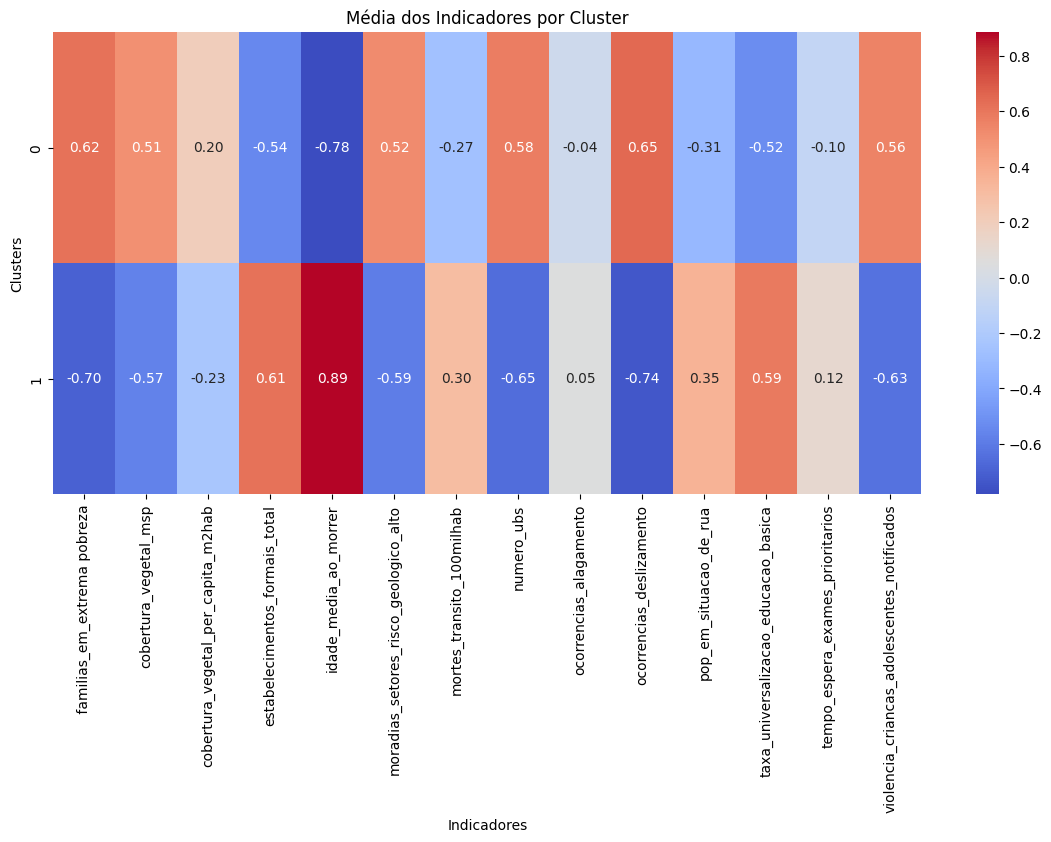


Cluster 0:
['Butantã', 'Campo Limpo', 'Capela Do Socorro', 'Cidade Ademar', 'Cidade Tiradentes', 'Freguesia-Brasilândia', 'Guaianases', 'Itaim Paulista', 'Itaquera', 'Jaçanã-Tremembé', "M'Boi Mirim", 'Parelheiros', 'Perus', 'Pirituba-Jaraguá', 'Sapopemba', 'São Mateus', 'São Miguel']

Cluster 1:
['Aricanduva-Formosa-Carrão', 'Casa Verde-Cachoeirinha', 'Ermelino Matarazzo', 'Ipiranga', 'Jabaquara', 'Lapa', 'Mooca', 'Penha', 'Pinheiros', 'Santana-Tucuruvi', 'Santo Amaro', 'Sé', 'Vila Maria-Vila Guilherme', 'Vila Mariana', 'Vila Prudente']


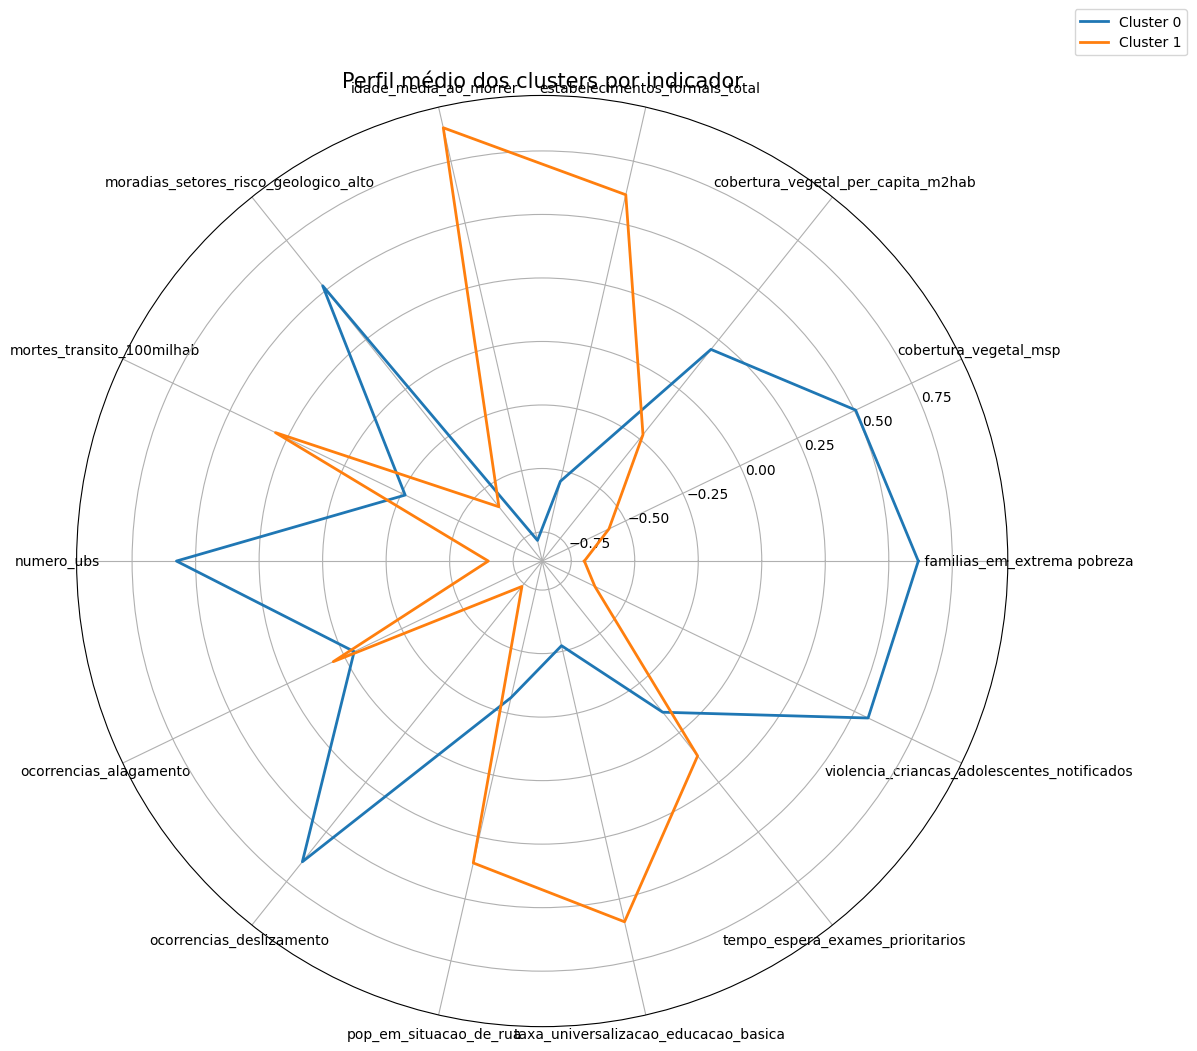

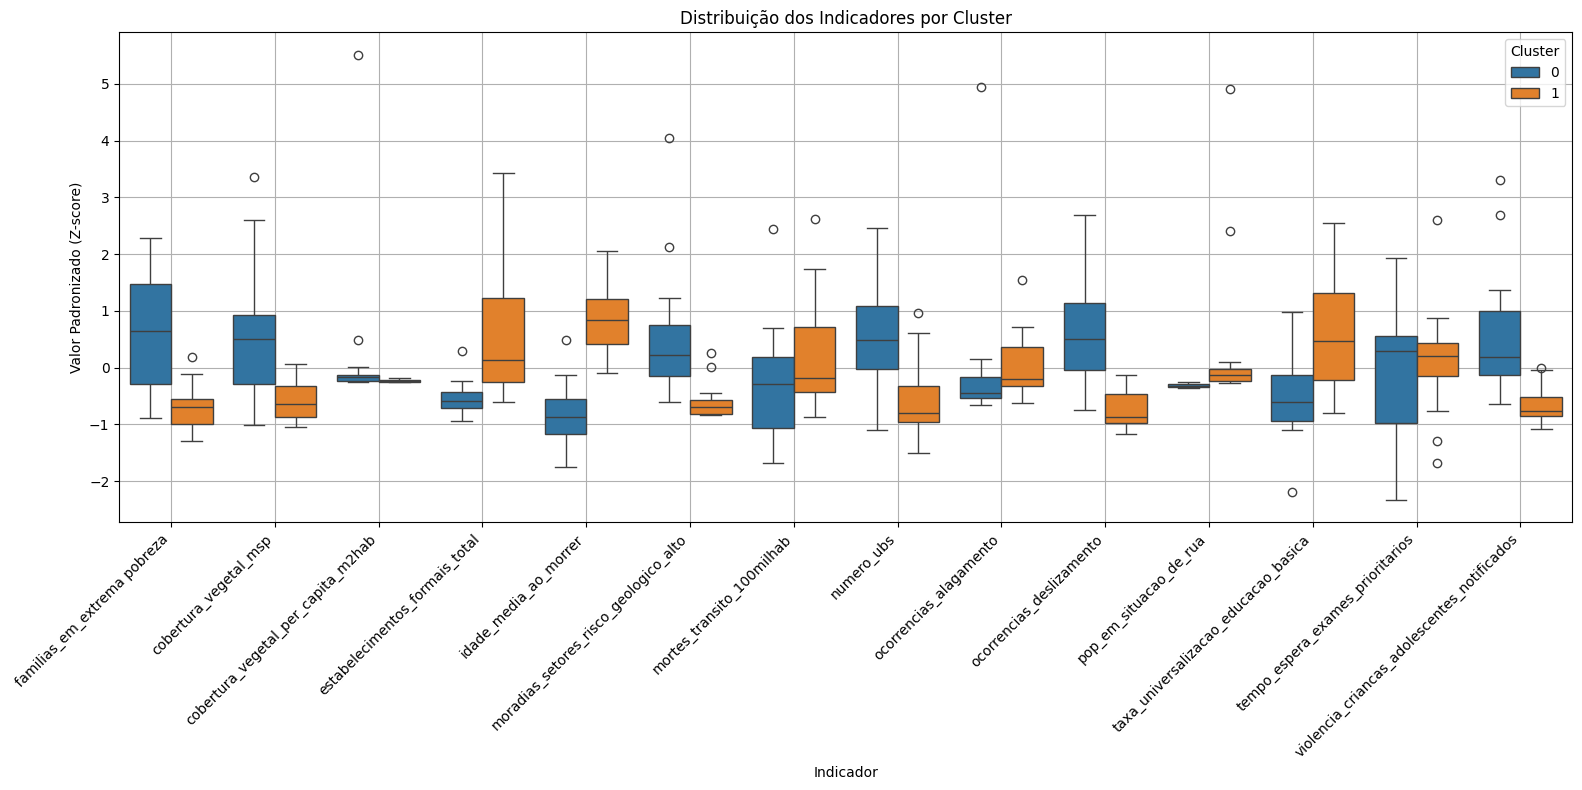

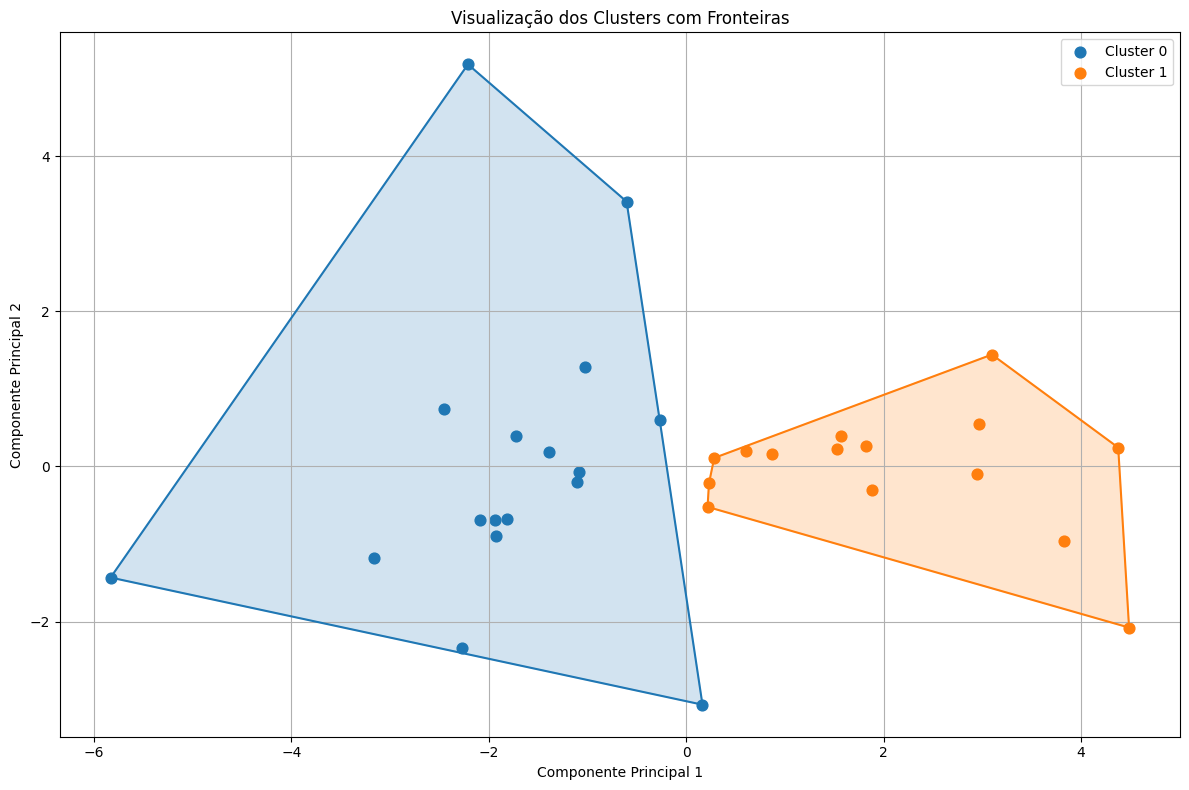

In [ ]:
# padronizando os dados para usar no cluster
scaler = StandardScaler()
dados_escalados = scaler.fit_transform(df_pivot)

df_escalado = pd.DataFrame(dados_escalados, index=df_pivot.index, columns=df_pivot.columns)

# clustering pelo modelo de k-means

# número de clusters (primeiro teste com 4)
k = 4

# Aplicar o KMeans
modelo_kmeans = KMeans(n_clusters=k, random_state=42)
labels = modelo_kmeans.fit_predict(df_escalado)

# Avaliar a qualidade do agrupamento
score = silhouette_score(df_escalado, labels)
print(f"Silhouette Score: {score:.2f}")

# testando vários valores de k

faixa_k = range(2, 13)
scores = []

for k in faixa_k:
    modelo = KMeans(n_clusters=k, random_state=42)
    labels = modelo.fit_predict(df_escalado)
    score = silhouette_score(df_escalado, labels)
    scores.append(score)
    print(f"k = {k} -> Silhouette Score: {score:.3f}")

# Plotar dos resultados
plt.figure(figsize=(10, 5))
plt.plot(faixa_k, scores, marker='o', linestyle='--')
plt.title("Silhouette Score para diferentes valores de k")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# removendo os índices com coef maior que 0.85 detectados anteriormente (silhouette score demonstrou valores muito baixos usando todos os indicadores)
removidos = [
    'domicilios_sem_agua_percentual',
    'domicilios_sem_esgoto_percentual',
    'empregos_formais_municipio_total',
    'familias_transferencia_renda',
    'livros_servicos_leitura_1000hab',
    'proporcao_gestantes_adolescentes',
    'taxa_mortalidade_infantil',
    'violencia_pessoas_idosas_notificados'
]

# Criar novo DataFrame sem essas colunas
df_filtrado = df_escalado.drop(columns= removidos)

# aplicando o teste novamente
faixa_k = range(2, 13)
scores = []

for k in faixa_k:
    modelo = KMeans(n_clusters=k, random_state=42)
    labels = modelo.fit_predict(df_filtrado)
    score = silhouette_score(df_filtrado, labels)
    scores.append(score)
    print(f"k = {k} -> Silhouette Score: {score:.3f}")

# Plotar dos resultados
plt.figure(figsize=(10, 5))
plt.plot(faixa_k, scores, marker='o', linestyle='--')
plt.title("Silhouette Score para diferentes valores de k")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show() # seguindo a análise com k=2

k = 2
modelo_kmeans = KMeans(n_clusters=k, random_state=42)
labels = modelo_kmeans.fit_predict(df_filtrado)

# adicionando os rótulos
df_escalado_com_cluster = df_filtrado.copy()
df_escalado_com_cluster['cluster'] = labels

# calculando as médias dos clusters
medias_por_cluster = df_escalado_com_cluster.groupby('cluster').mean()
pd.set_option('display.max_columns', None)
print(medias_por_cluster)

# heatmap dos clisters para facilitar a vizualização
plt.figure(figsize=(14, 6))
sns.heatmap(medias_por_cluster, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Média dos Indicadores por Cluster")
plt.xlabel("Indicadores")
plt.ylabel("Clusters")
plt.show()

# Visualizar os bairros em cada cluster
for i in range(2):
    print(f"\nCluster {i}:")
    print(df_escalado_com_cluster[df_escalado_com_cluster['cluster'] == i].index.tolist())

# plotando os clusters
# gráfico de radar
categorias = list(medias_por_cluster.columns)
num_variaveis = len(categorias)

angles = np.linspace(0, 2 * np.pi, num_variaveis, endpoint=False).tolist()
angles += angles[:1]

# Plotar um gráfico radar para cada cluster
plt.figure(figsize=(12, 12))

for i, row in medias_por_cluster.iterrows():
    valores = row.tolist()
    valores += valores[:1]  # fecha o círculo
    plt.polar(angles, valores, label=f'Cluster {i}', linewidth=2)


plt.xticks(angles[:-1], categorias, rotation=90)
plt.title("Perfil médio dos clusters por indicador", size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

# juntar os dados filtrados com o cluster
df_boxplot = df_filtrado.copy()
df_boxplot['cluster'] = labels  # labels vêm do KMeans

# transformar em formato longo para o Seaborn (melt)
df_meltado = df_boxplot.reset_index().melt(id_vars=['região', 'cluster'],
                                           var_name='Indicador',
                                           value_name='Valor')

# plotar
plt.figure(figsize=(16, 8))
sns.boxplot(x='Indicador', y='Valor', hue='cluster', data=df_meltado, palette='tab10')
plt.title('Distribuição dos Indicadores por Cluster')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Valor Padronizado (Z-score)')
plt.xlabel('Indicador')
plt.legend(title='Cluster')
plt.tight_layout()
plt.grid(True)
plt.show()

from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# PCA para reduzir a dimensão para 2
pca = PCA(n_components=2)
dados_2d = pca.fit_transform(df_filtrado)

df_vis = pd.DataFrame(dados_2d, columns=['PC1', 'PC2'])
df_vis['cluster'] = labels

# plot com área delimitando cada cluster
plt.figure(figsize=(12, 8))
paleta = sns.color_palette("tab10", len(df_vis['cluster'].unique()))

for i in sorted(df_vis['cluster'].unique()):
    grupo = df_vis[df_vis['cluster'] == i]
    plt.scatter(grupo['PC1'], grupo['PC2'], label=f"Cluster {i}", color=paleta[i], s=60)
    if len(grupo) >= 3:
        pontos = grupo[['PC1', 'PC2']].values
        hull = ConvexHull(pontos)
        vertices = pontos[hull.vertices]
        plt.fill(vertices[:, 0], vertices[:, 1], color=paleta[i], alpha=0.2)
        for simplex in hull.simplices:
            plt.plot(pontos[simplex, 0], pontos[simplex, 1], color=paleta[i], linewidth=1.5)

plt.title("Visualização dos Clusters com Fronteiras")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Cluster 0: Bairros com alta vulnerabilidade
-Esse cluster agrupa regiões com maior vulnerabilidade social, alta precariedade urbana (alagamentos, deslizamentos), baixa cobertura vegetal, mais espera por exames prioritários, e alta pobreza extrema, segundo o resultado dos índices.

Cluster 1: Bairros com melhor infraestrutura
-Esse cluster agrupa regiões com melhor infraestrutura urbana, menor vulnerabilidade social, melhores condições de saúde e acesso, e menos impacto ambiental adverso, segundo o resultado dos índices.




Analisando os dados para o ano mais recente: 2024

DataFrame pronto para clustering, sem valores ausentes.

Amostra do DataFrame a ser clusterizado:
nome_indicador              familias_em_extrema pobreza  \
região                                                    
Aricanduva-Formosa-Carrão                        9005.0   
Butantã                                         14386.0   
Campo Limpo                                     27896.0   
Capela Do Socorro                               33590.0   
Casa Verde-Cachoeirinha                         14120.0   

nome_indicador             familias_transferencia_renda  \
região                                                    
Aricanduva-Formosa-Carrão                       10131.0   
Butantã                                         18653.0   
Campo Limpo                                     38807.0   
Capela Do Socorro                               45633.0   
Casa Verde-Cachoeirinha                         17681.0   

nome_indicador         

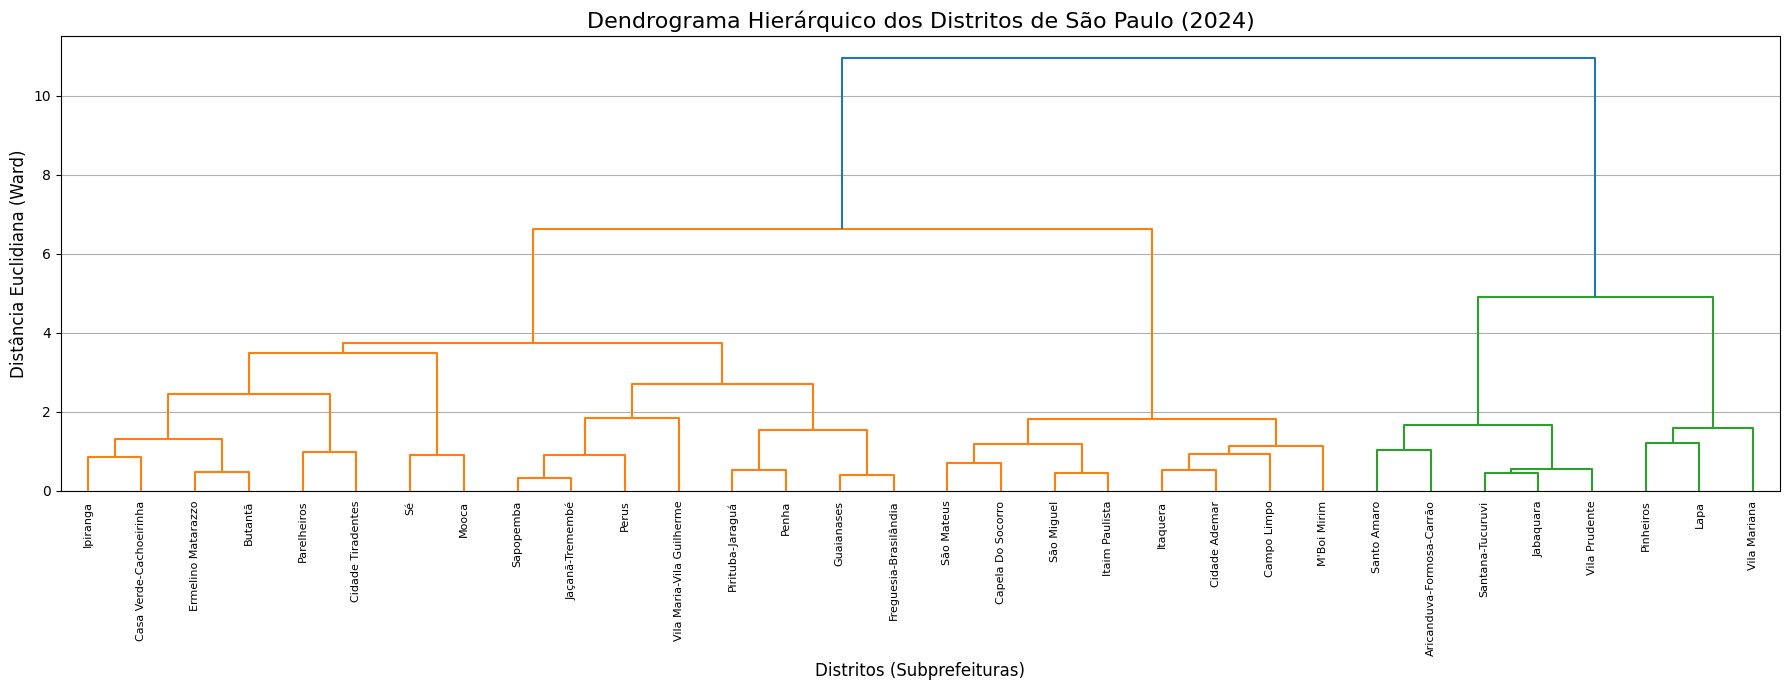

In [ ]:
# converter a coluna 'ano' para tipo numérico para encontrar o mais recente
df_concatenado['ano'] = pd.to_numeric(df_concatenado['ano'])
ano_recente = df_concatenado['ano'].max()
print(f"Analisando os dados para o ano mais recente: {ano_recente}\n")

# filtrar o DataFrame para conter apenas dados do ano mais recente
df_ano_recente = df_concatenado[df_concatenado['ano'] == ano_recente]

# criar a tabela pivotada (formato largo)
df_cluster = df_ano_recente.pivot_table(
    index='região',
    columns='nome_indicador',
    values='valor'
)

# checar e preencher valores ausentes (se houver)
if df_cluster.isnull().sum().sum() > 0:
    print("Valores ausentes encontrados após o pivot. Preenchendo com a média da coluna.")
    df_cluster.fillna(df_cluster.mean(), inplace=True)
else:
    print("DataFrame pronto para clustering, sem valores ausentes.")

print("\nAmostra do DataFrame a ser clusterizado:")
print(df_cluster.head())


# normalizar os dados

scaler = StandardScaler()
dados_escalados = scaler.fit_transform(df_cluster)

# novo DataFrame com os dados escalados para clareza
df_escalado = pd.DataFrame(dados_escalados, index=df_cluster.index, columns=df_cluster.columns)

print("\nDados normalizados com sucesso.")
print("Amostra do DataFrame normalizado:")
print(df_escalado.head())


# gerar o dendrograma com clustering hierárquico

# ward minimiza a variância dentro de cada cluster.
linked = linkage(df_escalado, method='ward')

# configurar e plotar o dendrograma
plt.figure(figsize=(18, 7))
dendrogram(linked,
           orientation='top',
           labels=list(df_cluster.index),
           distance_sort='descending',
           show_leaf_counts=True)

plt.title(f'Dendrograma Hierárquico dos Distritos de São Paulo ({ano_recente})', fontsize=16)
plt.xlabel('Distritos (Subprefeituras)', fontsize=12)
plt.ylabel('Distância Euclidiana (Ward)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



Para n_clusters = 5, o Silhouette Score médio é: 0.3100

--- Média dos Indicadores por Cluster ---
nome_indicador   familias_em_extrema pobreza  familias_transferencia_renda  \
cluster                                                                      
0                               17896.750000                  20371.125000   
1                               17668.125000                  23481.750000   
2                               30642.875000                  39106.625000   
3                                7645.333333                   3691.333333   
4                                8823.400000                   9873.800000   

nome_indicador  proporcao_gestantes_adolescentes  taxa_mortalidade_infantil  
cluster                                                                      
0                                       6.860275                   9.848287  
1                                       8.280313                  13.227213  
2                                       8.

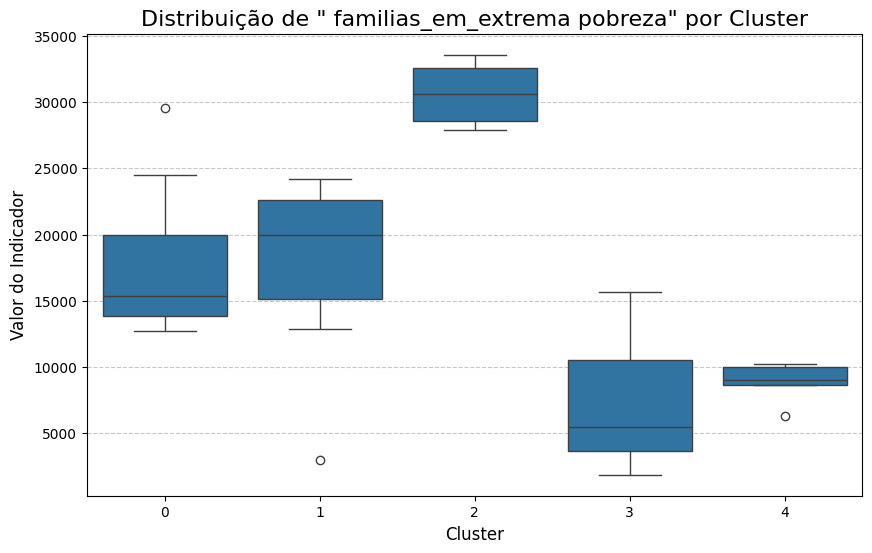

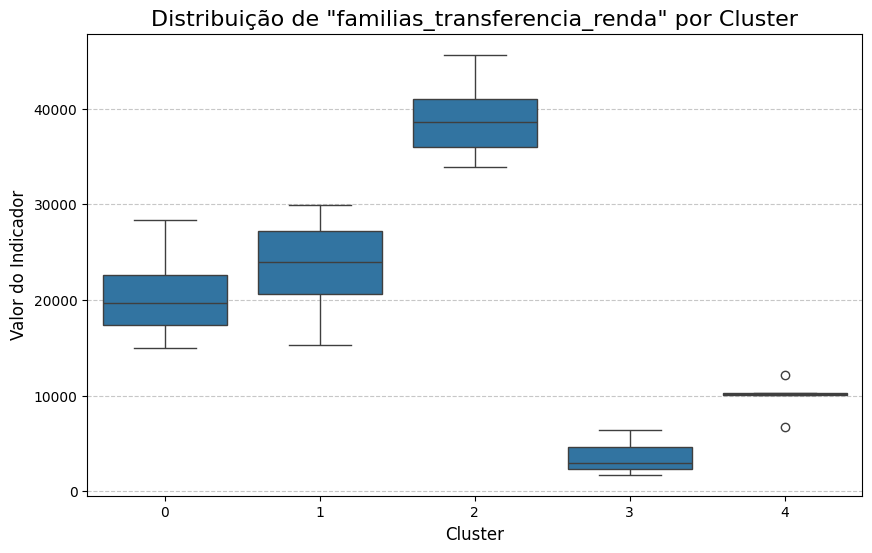

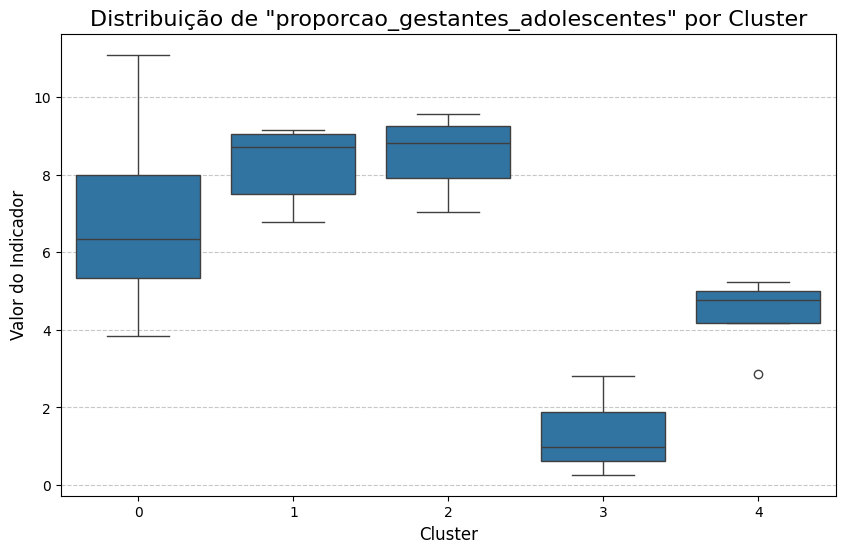

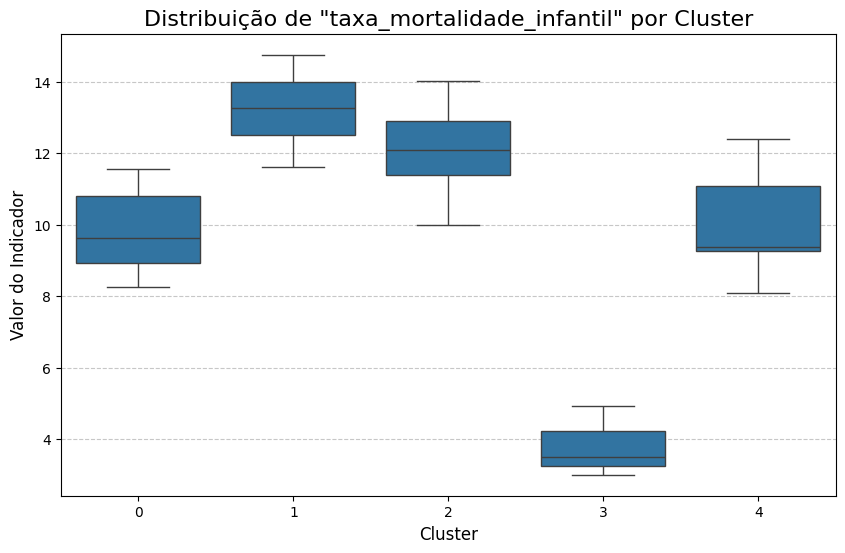

In [ ]:
# criar os clusters e validar a qualidade ---

numero_de_clusters = 5

# instanciar e aplicar o modelo de clustering aglomerativo
cluster_model = AgglomerativeClustering(n_clusters=numero_de_clusters, metric='euclidean', linkage='ward')
cluster_labels = cluster_model.fit_predict(df_escalado)

# calcular o Silhouette Score
# Um valor próximo de 1 indica clusters densos e bem separados.
silhouette_avg = silhouette_score(df_escalado, cluster_labels)
print(f"Para n_clusters = {numero_de_clusters}, o Silhouette Score médio é: {silhouette_avg:.4f}\n")

# adicionar os rótulos dos clusters ao nosso dataframe original (não escalado) para interpretação
df_cluster['cluster'] = cluster_labels


# interpretar e visualizar os clusters ---

print("--- Média dos Indicadores por Cluster ---")
# agrupar por cluster e calcular a média de cada indicadors isso nos dá um perfil quantitativo de cada grupo.
cluster_summary = df_cluster.groupby('cluster').mean()
print(cluster_summary)

print("\n--- Visualização dos Clusters com Boxplots ---")
# para cada indicador, vamos criar um boxplot para comparar as distribuições entre os clusters, isso ajuda a visualizar as diferenças que definem cada grupo.
for column in df_cluster.columns.drop('cluster'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=column, data=df_cluster)
    plt.title(f'Distribuição de "{column}" por Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Valor do Indicador', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



DataFrame preparado e normalizado com sucesso.

--- Iniciando a Otimização para: Análise Multidimensional ---
Para k = 2, o Silhouette Score é: 0.2864
Para k = 3, o Silhouette Score é: 0.2595
Para k = 4, o Silhouette Score é: 0.2456
Para k = 5, o Silhouette Score é: 0.2656
Para k = 6, o Silhouette Score é: 0.2714
Para k = 7, o Silhouette Score é: 0.2682
Para k = 8, o Silhouette Score é: 0.2834
Para k = 9, o Silhouette Score é: 0.2999
Para k = 10, o Silhouette Score é: 0.3166
Para k = 11, o Silhouette Score é: 0.3098
Para k = 12, o Silhouette Score é: 0.3247
Para k = 13, o Silhouette Score é: 0.3123
Para k = 14, o Silhouette Score é: 0.3048
Para k = 15, o Silhouette Score é: 0.2937
Para k = 16, o Silhouette Score é: 0.2887
Para k = 17, o Silhouette Score é: 0.2766
Para k = 18, o Silhouette Score é: 0.2767
Para k = 19, o Silhouette Score é: 0.2554
Para k = 20, o Silhouette Score é: 0.2323


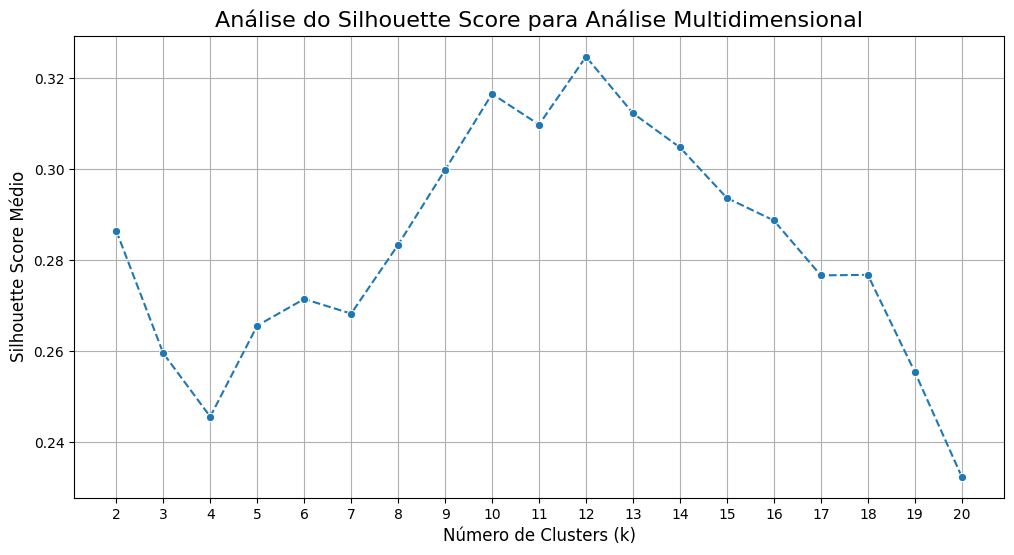


Para a 'Análise Multidimensional', o valor ideal de k é 12 com um Score de 0.3247.
--------------------------------------------------

--- Rodando a análise final com o k ótimo encontrado: 12 ---

--- Média dos Indicadores por Cluster ---
nome_indicador  familias_em_extrema pobreza  idade_media_ao_morrer  \
cluster                                                              
0                               7645.333333              78.730000   
1                              23313.500000              72.650000   
2                              25779.600000              64.498000   
3                              12817.333333              70.633333   
4                              15492.000000              64.646667   
5                              30071.000000              64.153333   
6                              31306.500000              65.035000   
7                              15542.000000              59.480000   
8                               5998.000000              71.

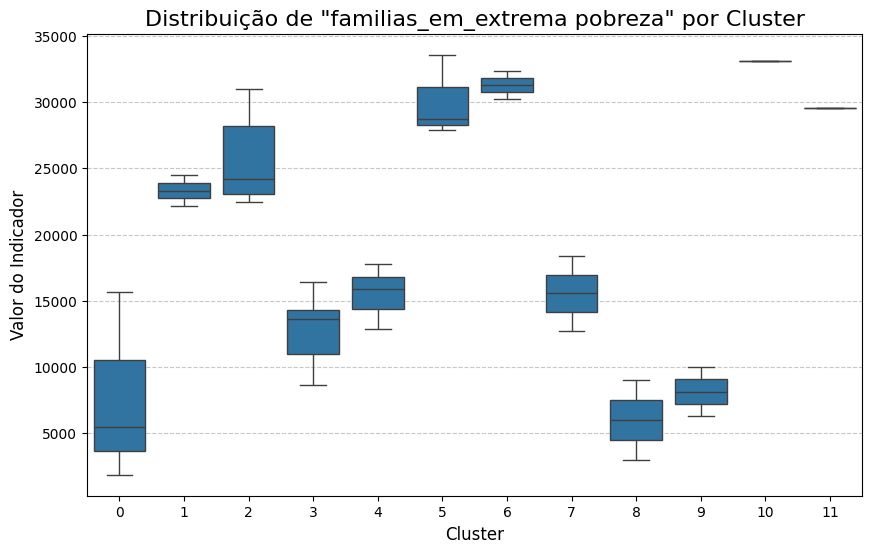

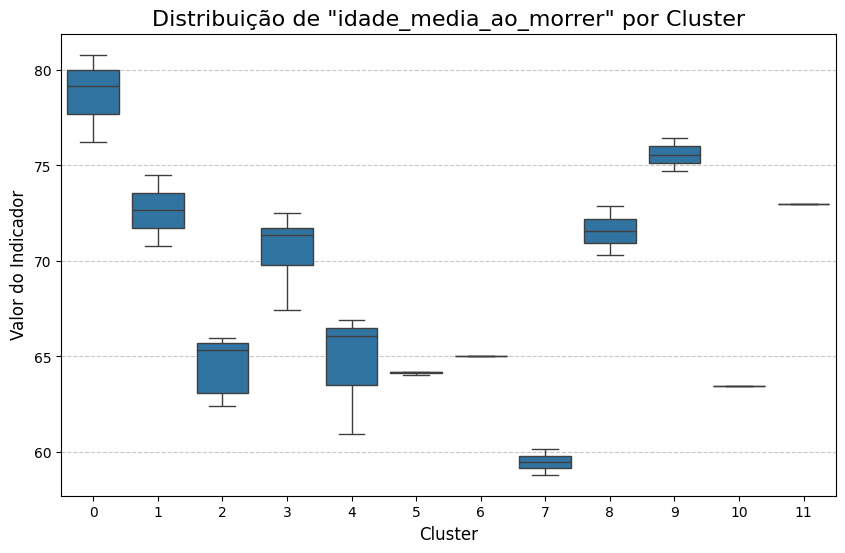

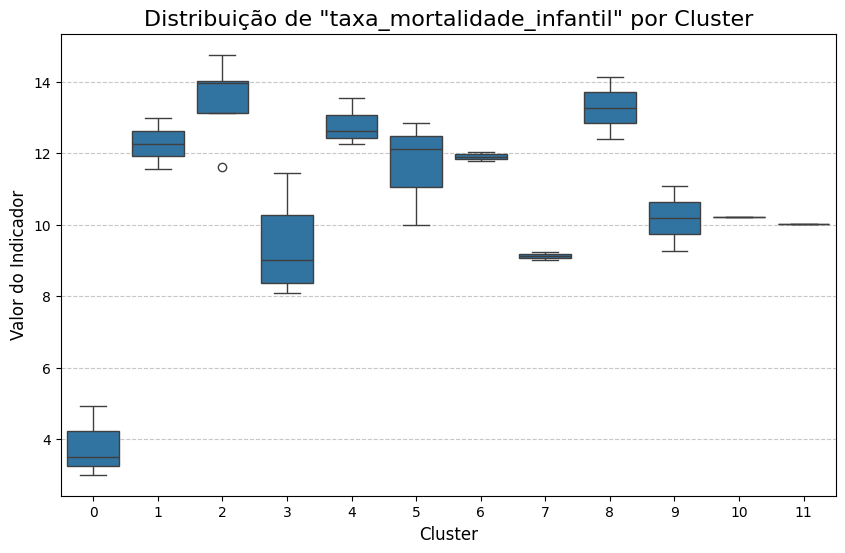

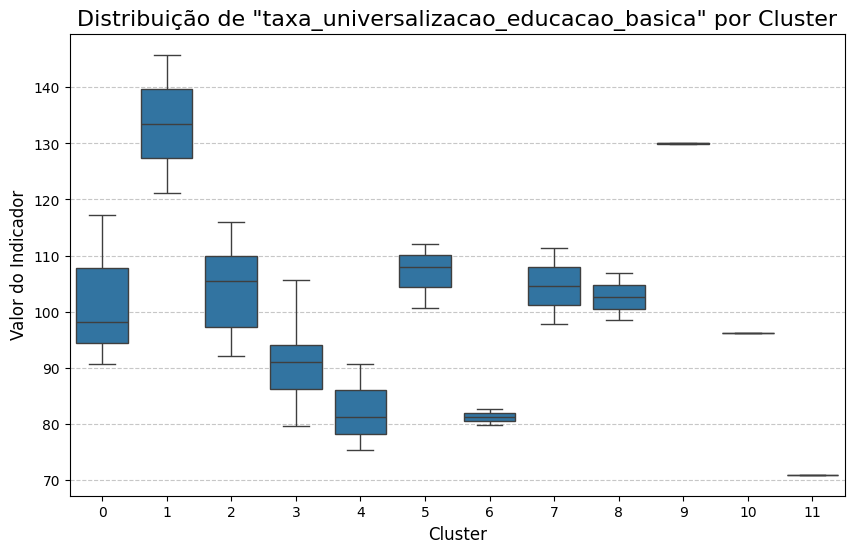

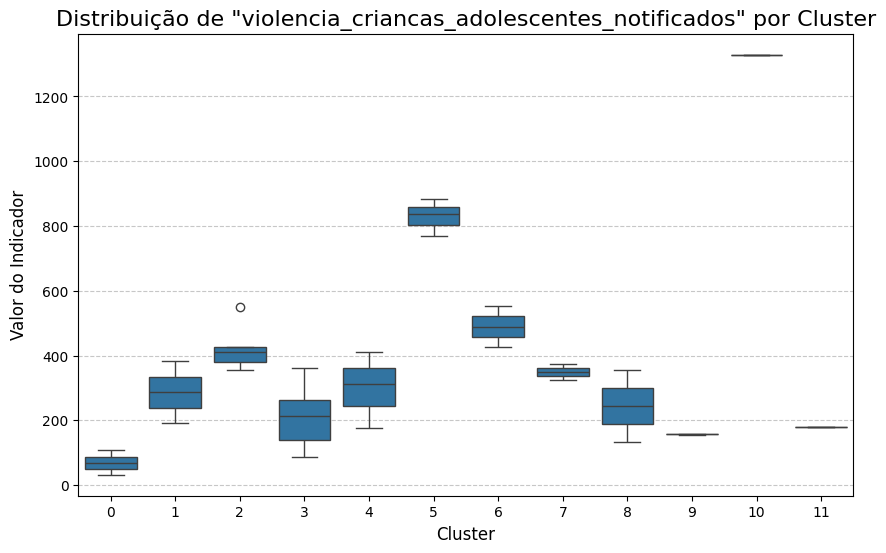

In [ ]:
# arrumar nomes dos indicadores (remove espaços em branco no início/fim dos nomes)
df_concatenado['nome_indicador'] = df_concatenado['nome_indicador'].str.strip()

# selecionar os indicadores para a análise
indicadores_selecionados = [
    'familias_em_extrema pobreza',
    'taxa_universalizacao_educacao_basica',
    'idade_media_ao_morrer',
    'taxa_mortalidade_infantil',
    'violencia_criancas_adolescentes_notificados'
]

# filtrar o dataframe principal
df_filtrado = df_concatenado[df_concatenado['nome_indicador'].isin(indicadores_selecionados)].copy()

# converter 'ano' para numérico para garantir a ordenação correta
df_filtrado['ano'] = pd.to_numeric(df_filtrado['ano'])

# Em vez de filtrar por um único ano, pegamos o dado mais recente para cada indicador/região.
# 1. ordenar por ano para que o mais recente fique por último.
df_filtrado_sorted = df_filtrado.sort_values(by='ano')

# 2. remover duplicatas de indicador/região, mantendo apenas a última ocorrência (a mais recente).
df_latest = df_filtrado_sorted.drop_duplicates(subset=['região', 'nome_indicador'], keep='last')

# criar a tabela pivotada (formato largo) a partir dos dados mais recentes de cada indicador
df_cluster = df_latest.pivot_table(
    index='região',
    columns='nome_indicador',
    values='valor'
)

# checar e preencher valores ausentes (pode ocorrer se uma região não tiver um indicador)
if df_cluster.isnull().sum().sum() > 0:
    print(f"Encontrados {df_cluster.isnull().sum().sum()} valores ausentes. Preenchendo com a média da coluna.")
    df_cluster.fillna(df_cluster.mean(), inplace=True)

# normalizar os dados
scaler = StandardScaler()
dados_escalados = scaler.fit_transform(df_cluster)
df_escalado = pd.DataFrame(dados_escalados, index=df_cluster.index, columns=df_cluster.columns)
print("DataFrame preparado e normalizado com sucesso.\n")


# ==============================================================================
#  ENCONTRAR O NÚMERO IDEAL DE CLUSTERS (k)
# ==============================================================================

def encontrar_melhor_k(dados_escalados, nome_analise):
    k_range = range(2, 21)
    silhouette_scores = []
    print(f"--- Iniciando a Otimização para: {nome_analise} ---")
    for k in k_range:
        model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
        labels = model.fit_predict(dados_escalados)
        score = silhouette_score(dados_escalados, labels)
        silhouette_scores.append(score)
        print(f"Para k = {k}, o Silhouette Score é: {score:.4f}")

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=list(k_range), y=silhouette_scores, marker='o', linestyle='--')
    plt.title(f'Análise do Silhouette Score para {nome_analise}', fontsize=16)
    plt.xlabel('Número de Clusters (k)', fontsize=12)
    plt.ylabel('Silhouette Score Médio', fontsize=12)
    plt.xticks(list(k_range))
    plt.grid(True)
    plt.show()

    melhor_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    melhor_score = max(silhouette_scores)
    print(f"\nPara a '{nome_analise}', o valor ideal de k é {melhor_k} com um Score de {melhor_score:.4f}.")
    print("--------------------------------------------------\n")
    return melhor_k

# chamar a função para encontrar o k
k_otimo = encontrar_melhor_k(df_escalado, "Análise Multidimensional")


# ==============================================================================
# ANÁLISE FINAL COM O 'k' OTIMIZADO
# ==============================================================================

print(f"--- Rodando a análise final com o k ótimo encontrado: {k_otimo} ---")

# aplicar o modelo de clustering com o número ideal de clusters
cluster_model_final = AgglomerativeClustering(n_clusters=k_otimo, metric='euclidean', linkage='ward')
cluster_labels_final = cluster_model_final.fit_predict(df_escalado)

# adicionar os rótulos dos clusters ao dataframe para interpretação
df_cluster['cluster'] = cluster_labels_final

# interpretar e visualizar os clusters finais ---
print("\n--- Média dos Indicadores por Cluster ---")
cluster_summary = df_cluster.groupby('cluster').mean()
print(cluster_summary)

print("\n--- Visualização dos Clusters com Boxplots ---")
for column in df_cluster.columns.drop('cluster'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=column, data=df_cluster)
    plt.title(f'Distribuição de "{column}" por Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Valor do Indicador', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

ANÁLISE APROFUNDADA E VISUALIZAÇÃO DOS CLUSTERS


--- Heatmap de Correlação entre os Indicadores ---


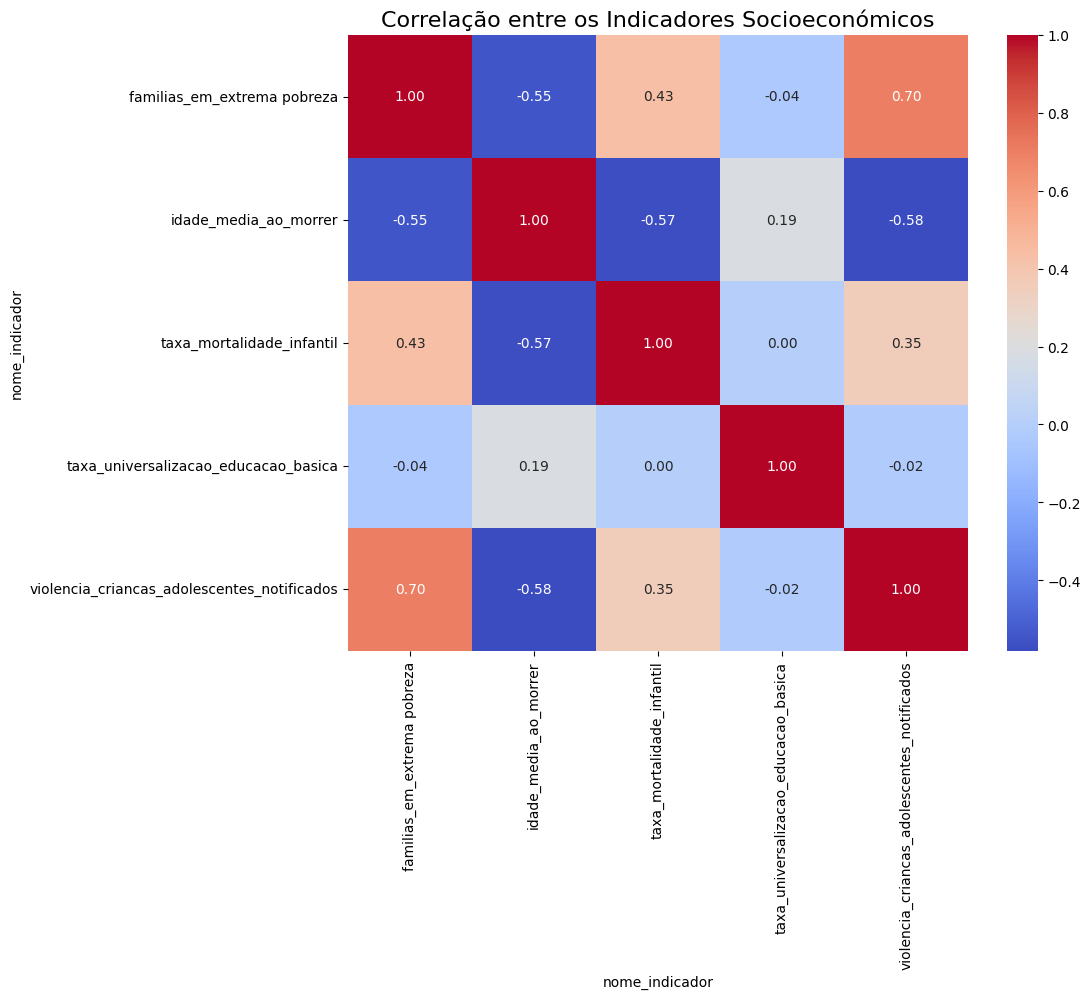


--- Visualização 2D dos Clusters com PCA (com Rótulos) ---


/tmp/ipython-input-828873957.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_pca['Componente Principal 1'][i]+0.05, df_pca['Componente Principal 2'][i], txt, fontsize=9)


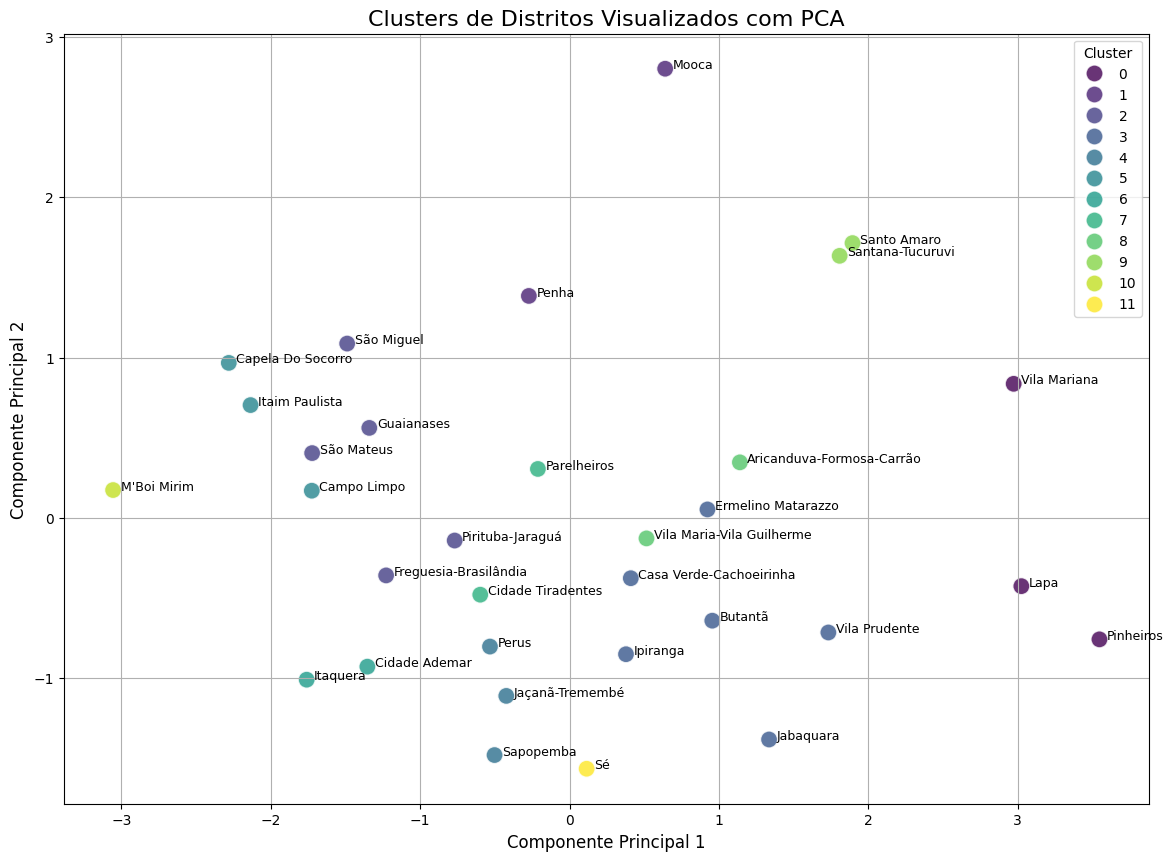


--- Gráfico de Radar para Comparar o Perfil dos Clusters ---


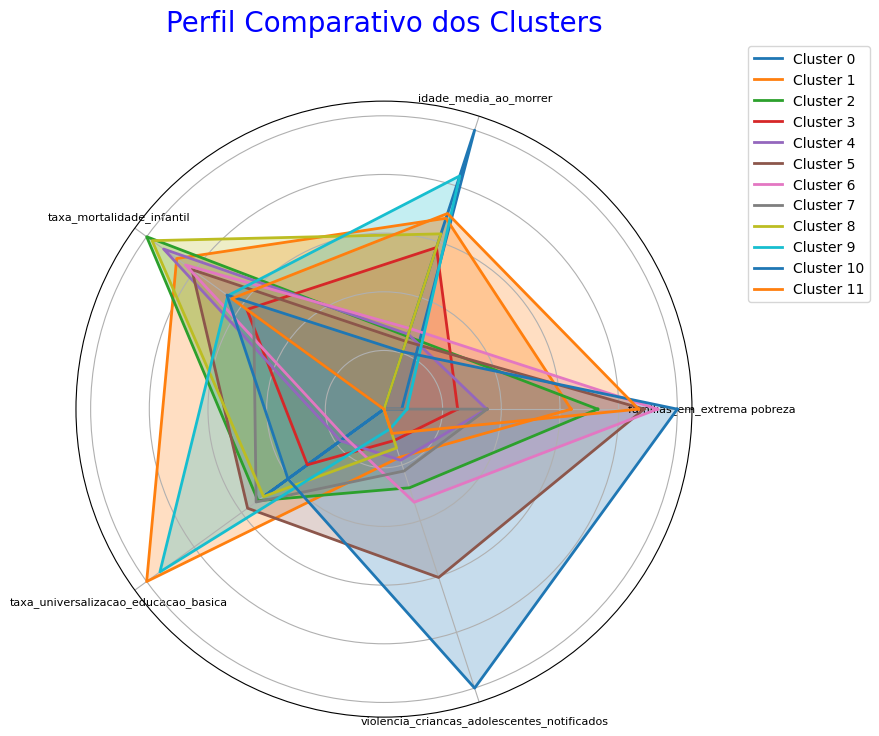

In [ ]:
# Heatmap de Correlação dos Indicadores
print("\n--- Heatmap de Correlação entre os Indicadores ---")
plt.figure(figsize=(10, 8))

# Usamos df_cluster.drop para remover a coluna 'cluster' antes de calcular a correlação
sns.heatmap(df_cluster.drop('cluster', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação entre os Indicadores Socioeconómicos', fontsize=16)
plt.show()


# visualização com análise de componentes principais (PCA)
print("\n--- Visualização 2D dos Clusters com PCA (com Rótulos) ---")
pca = PCA(n_components=2)
componentes_principais = pca.fit_transform(df_escalado)
df_pca = pd.DataFrame(data=componentes_principais, columns=['Componente Principal 1', 'Componente Principal 2'], index=df_cluster.index)
df_pca['cluster'] = df_cluster['cluster']

plt.figure(figsize=(14, 10))
sns.scatterplot(x='Componente Principal 1', y='Componente Principal 2', hue='cluster', data=df_pca, palette='viridis', s=150, alpha=0.8, legend='full')

# adicionar rótulos de texto para cada ponto
for i, txt in enumerate(df_pca.index):
    plt.text(df_pca['Componente Principal 1'][i]+0.05, df_pca['Componente Principal 2'][i], txt, fontsize=9)

plt.title('Clusters de Distritos Visualizados com PCA', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# gráfico de radar para comparar perfis dos clusters
print("\n--- Gráfico de Radar para Comparar o Perfil dos Clusters ---")
# Agrupar por cluster e calcular a média para o gráfico de radar
cluster_summary = df_cluster.groupby('cluster').mean()

# normalizar os dados do sumário para a escala 0-1
scaler_radar = MinMaxScaler()
df_radar = pd.DataFrame(scaler_radar.fit_transform(cluster_summary), index=cluster_summary.index, columns=cluster_summary.columns)

# adicionar o primeiro eixo no final para fechar o polígono do radar
labels = df_radar.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in df_radar.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {i}', linewidth=2)
    ax.fill(angles, values, alpha=0.25)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=8) # Ajustado para melhor visualização
plt.title('Perfil Comparativo dos Clusters', size=20, color='blue', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


Listar os Distritos de Cada Cluster

In [ ]:
for i in range(12):
    print(f"--- Distritos(subprefeituras) no Cluster {i} ---")
    distritos = df_cluster[df_cluster['cluster'] == i].index.tolist()

    if not distritos:
        print("Nenhum distrito neste cluster.")
    else:
        print(distritos)
    print("\n")


--- Distritos(subprefeituras) no Cluster 0 ---
['Lapa', 'Pinheiros', 'Vila Mariana']


--- Distritos(subprefeituras) no Cluster 1 ---
['Mooca', 'Penha']


--- Distritos(subprefeituras) no Cluster 2 ---
['Freguesia-Brasilândia', 'Guaianases', 'Pirituba-Jaraguá', 'São Mateus', 'São Miguel']


--- Distritos(subprefeituras) no Cluster 3 ---
['Butantã', 'Casa Verde-Cachoeirinha', 'Ermelino Matarazzo', 'Ipiranga', 'Jabaquara', 'Vila Prudente']


--- Distritos(subprefeituras) no Cluster 4 ---
['Jaçanã-Tremembé', 'Perus', 'Sapopemba']


--- Distritos(subprefeituras) no Cluster 5 ---
['Campo Limpo', 'Capela Do Socorro', 'Itaim Paulista']


--- Distritos(subprefeituras) no Cluster 6 ---
['Cidade Ademar', 'Itaquera']


--- Distritos(subprefeituras) no Cluster 7 ---
['Cidade Tiradentes', 'Parelheiros']


--- Distritos(subprefeituras) no Cluster 8 ---
['Aricanduva-Formosa-Carrão', 'Vila Maria-Vila Guilherme']


--- Distritos(subprefeituras) no Cluster 9 ---
['Santana-Tucuruvi', 'Santo Amaro']


---

Perfil Detalhado dos 12 Clusters

**Cluster 0: Ilhas de Prosperidade e Bem-Estar**

Perfil: Este é o grupo de elite. Apresenta a menor taxa de mortalidade infantil (3.8), a segunda maior idade média ao morrer (78.7) e os níveis mais baixos de pobreza e violência entre todos os clusters.

Nome Sugerido: Elite e Alta Qualidade de Vida.

**Cluster 1: Polos Educacionais com Desafios Sociais**

Perfil: Um grupo de contrastes. Possui a maior taxa de universalização da educação (133.5%), sugerindo um polo de atração de estudantes, mas ao mesmo tempo apresenta alta pobreza (23k famílias) e alta mortalidade infantil (12.2).

Nome Sugerido: Polos Educacionais em Meio à Vulnerabilidade.

**Cluster 2: Vulnerabilidade Crítica em Saúde e Pobreza**

Perfil: Este cluster se destaca negativamente pela altíssima taxa de mortalidade infantil (13.5, a maior de todas) e uma baixa idade média ao morrer (64.5), combinadas com alta pobreza (25.7k famílias).

Nome Sugerido: Crise em Saúde e Pobreza.

**Cluster 3: Distritos Intermediários-Baixos**

Perfil: Representa um perfil "mediano" para os padrões de São Paulo, mas com indicadores pendendo para o lado negativo. Níveis intermediários de pobreza, violência e saúde. A taxa de educação é notavelmente baixa (91.1).

Nome Sugerido: Desafios Moderados e Baixa Escolaridade.

**Cluster 4: Vulnerabilidade em Saúde e Educação**

Perfil: Um grupo com baixa idade média ao morrer (64.6), alta mortalidade infantil (12.8) e a segunda pior taxa de educação (82.4). A pobreza é intermediária.

Nome Sugerido: Crise em Saúde e Educação.

**Cluster 5: Pobreza e Violência Extremas**

Perfil: Caracterizado por níveis muito altos de pobreza (30k famílias) e o segundo maior índice de violência (829.3). Apesar disso, a taxa de educação é surpreendentemente boa (106.9).

Nome Sugerido: Pobreza Extrema e Alta Violência.

**Cluster 6: Crise Socioeducacional e de Segurança**

Perfil: Este grupo combina pobreza muito elevada (31.3k famílias) com uma taxa de educação muito baixa (81.1) e altos níveis de violência.

Nome Sugerido: Vulnerabilidade Socioeducacional Crítica.

**Cluster 7: Anomalia: Crise de Longevidade**

Perfil: Este cluster é um ponto fora da curva. A sua característica mais marcante é a idade média ao morrer drasticamente baixa (59.5 anos), a menor de todas. Os outros indicadores são intermediários, o que torna este resultado particularmente alarmante e digno de uma investigação mais a fundo.

Nome Sugerido: Crise de Longevidade.

**Cluster 8: Prosperidade com Lacunas na Saúde Infantil**

Perfil: Um grupo contraditório. Possui a menor quantidade de famílias em extrema pobreza (quase 6k), mas, paradoxalmente, uma das mais altas taxas de mortalidade infantil (13.3).

Nome Sugerido: Prosperidade com Desafios na Saúde Infantil.

**Cluster 9: Distritos de Alta Qualidade de Vida**

Perfil: Muito similar ao Cluster 0, mas um degrau abaixo. Apresenta baixa pobreza (8.1k famílias), alta idade ao morrer (75.6) e uma excelente taxa de educação (130).

Nome Sugerido: Qualidade de Vida Elevada.

**Cluster 10: Epicentros de Crise Múltipla**

Perfil: Este é, de longe, o cluster mais crítico. Apresenta a maior média de famílias em extrema pobreza (33.1k) e um nível de violência notificada astronomicamente alto (1329), quase o dobro do segundo pior.

Nome Sugerido: Epicentro da Crise Socioeconômica e de Segurança.

**Cluster 11: Déficit Educacional Crítico**

Perfil: A característica definidora deste grupo é a pior taxa de universalização da educação básica de todas (70.9), combinada com alta pobreza (29.5k famílias). Curiosamente, a violência notificada é relativamente baixa para um perfil tão vulnerável.

Nome Sugerido: Vulnerabilidade Educacional Crítica.


--- Contagem de Distritos por Cluster ---


/tmp/ipython-input-2938660063.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df_cluster, palette='viridis')


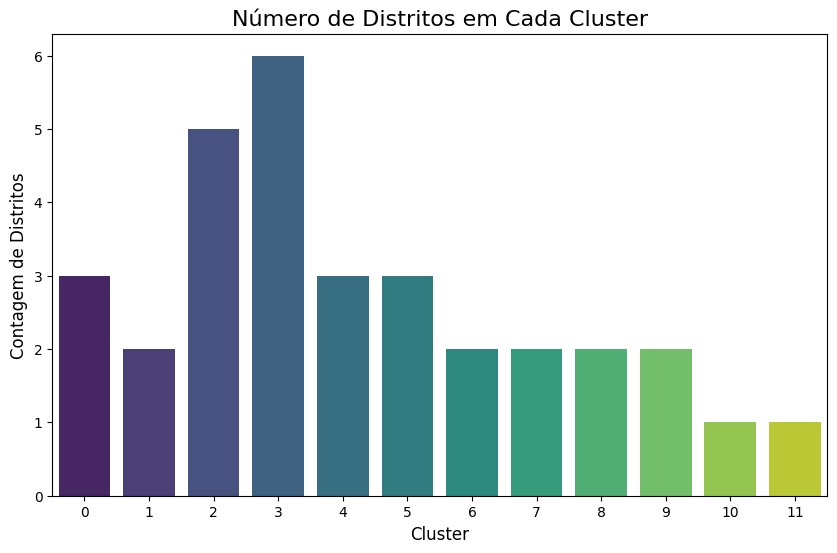


--- Gráfico de Dispersão Par a Par (Pair Plot) ---


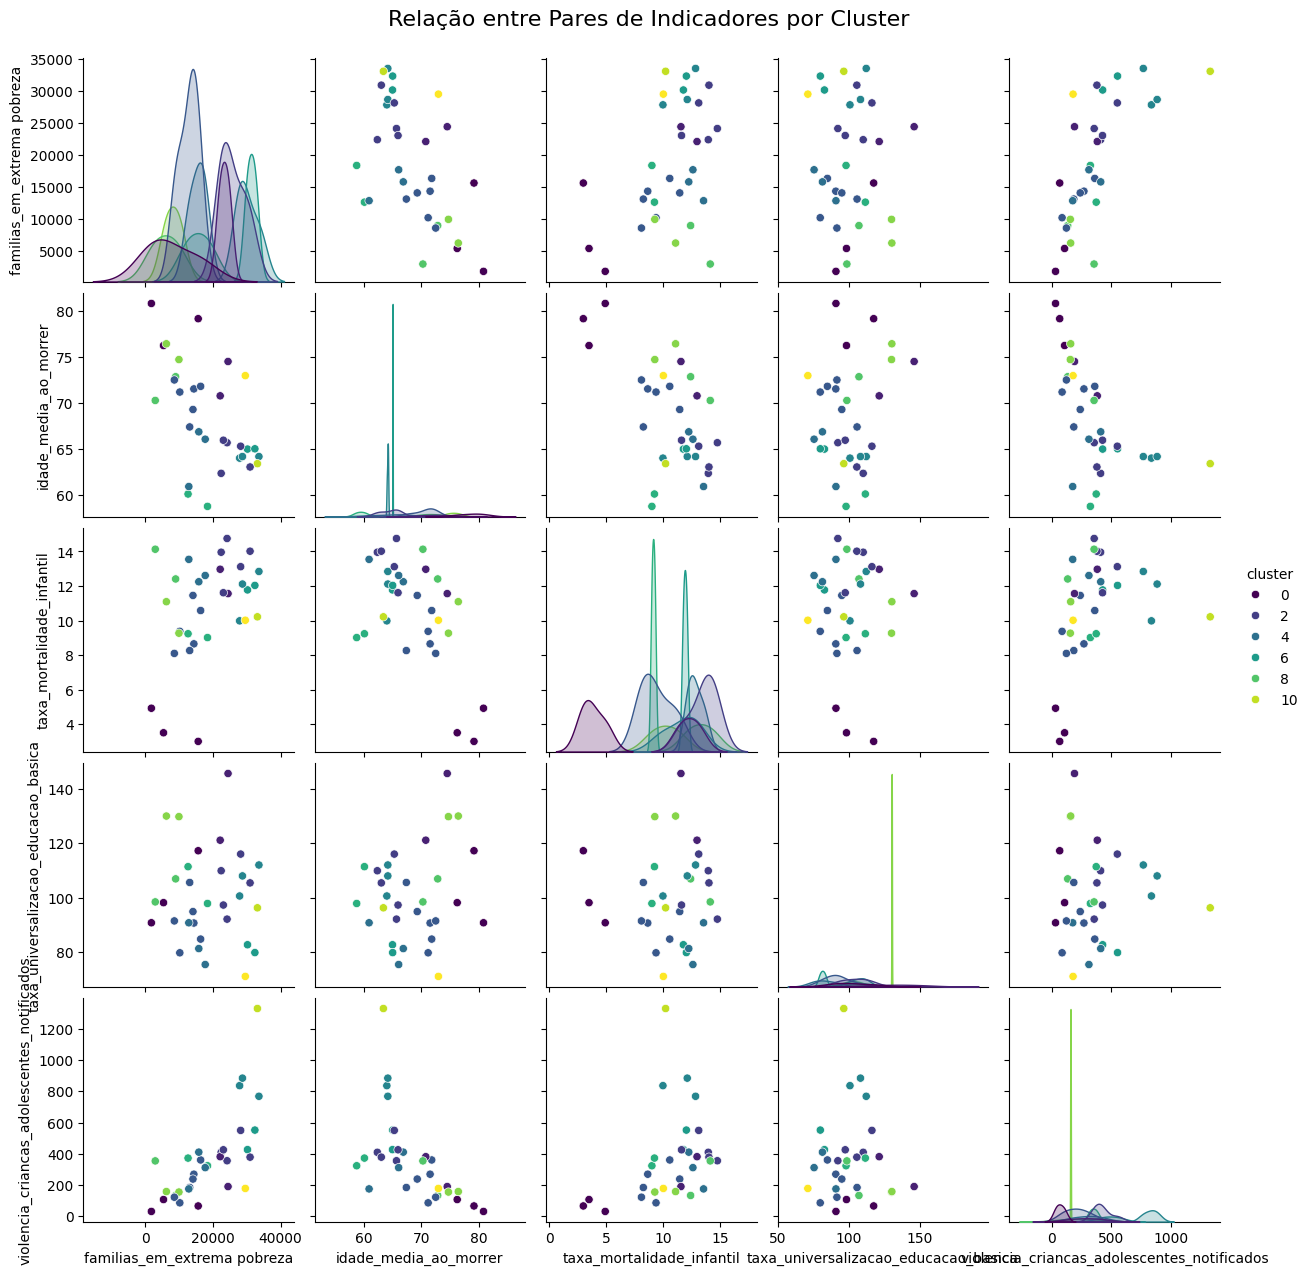


--- Visualização dos Clusters com Gráficos de Violino ---


/tmp/ipython-input-2938660063.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=column, data=df_cluster, palette='muted')


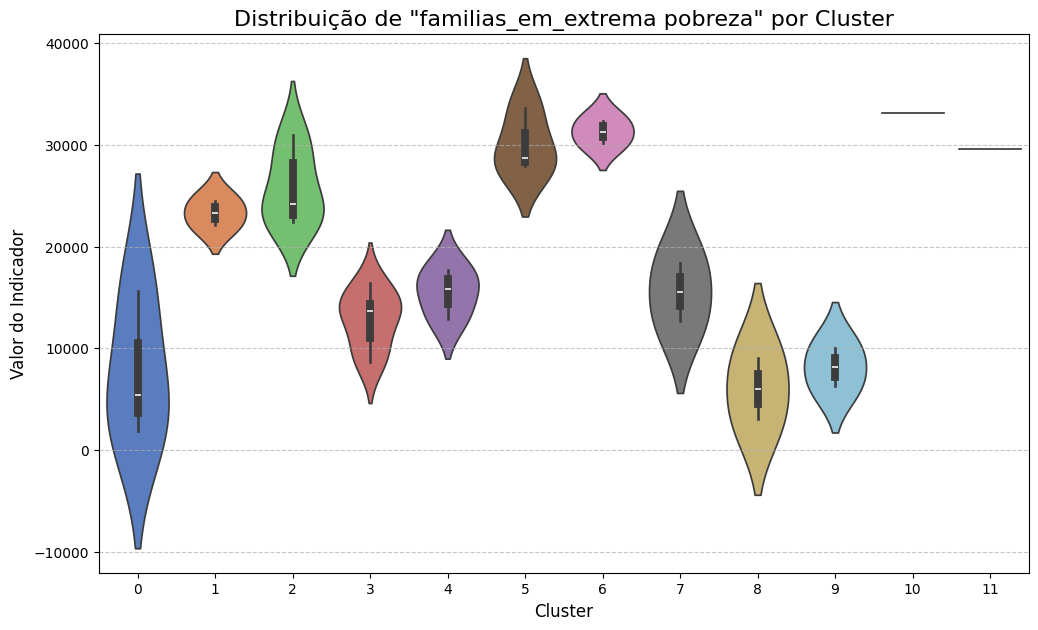

/tmp/ipython-input-2938660063.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=column, data=df_cluster, palette='muted')


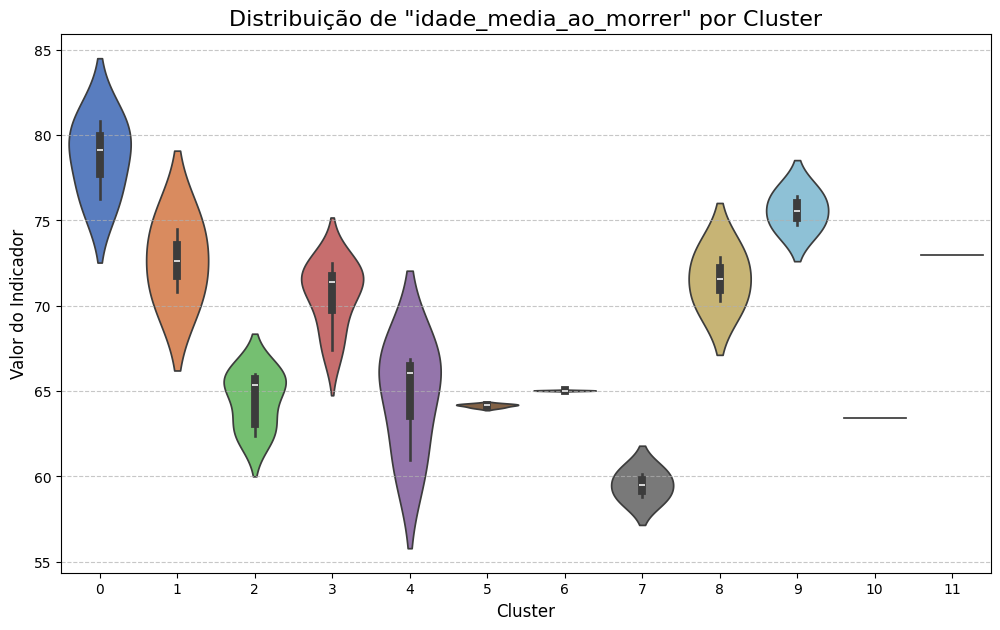

/tmp/ipython-input-2938660063.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=column, data=df_cluster, palette='muted')


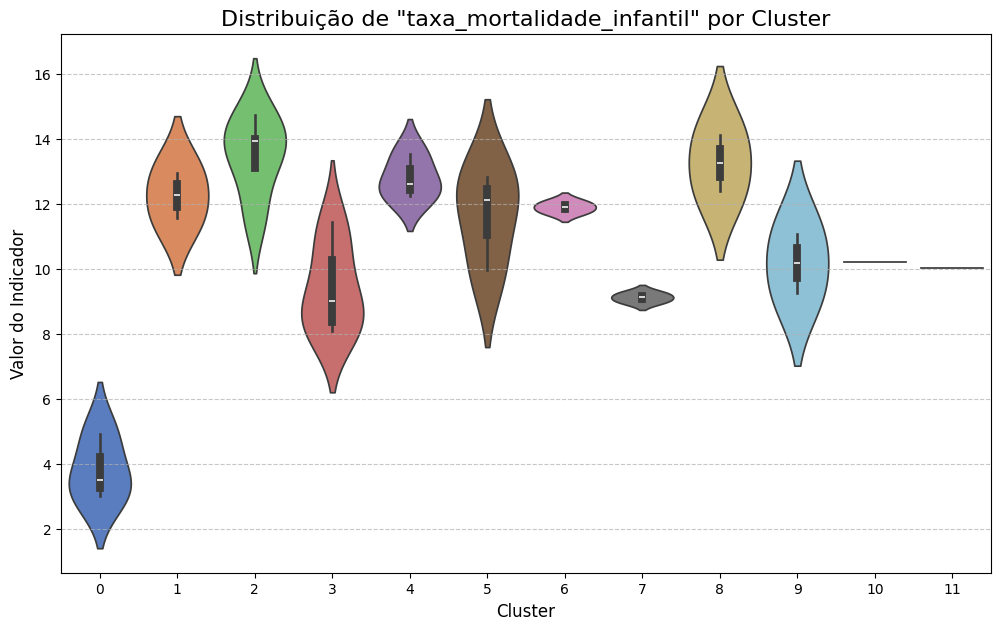

/tmp/ipython-input-2938660063.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=column, data=df_cluster, palette='muted')


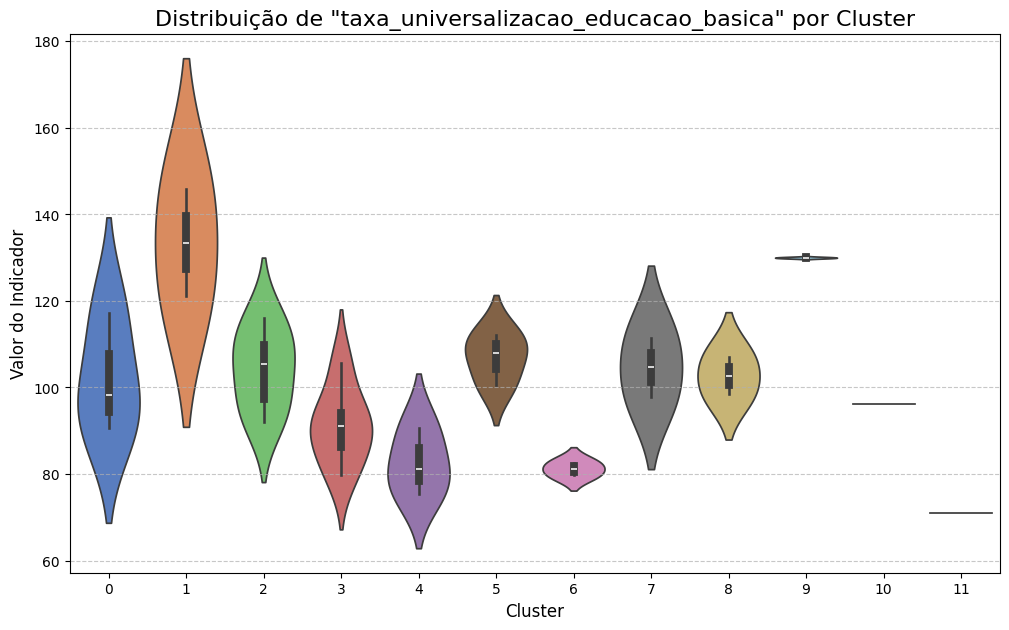

/tmp/ipython-input-2938660063.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=column, data=df_cluster, palette='muted')


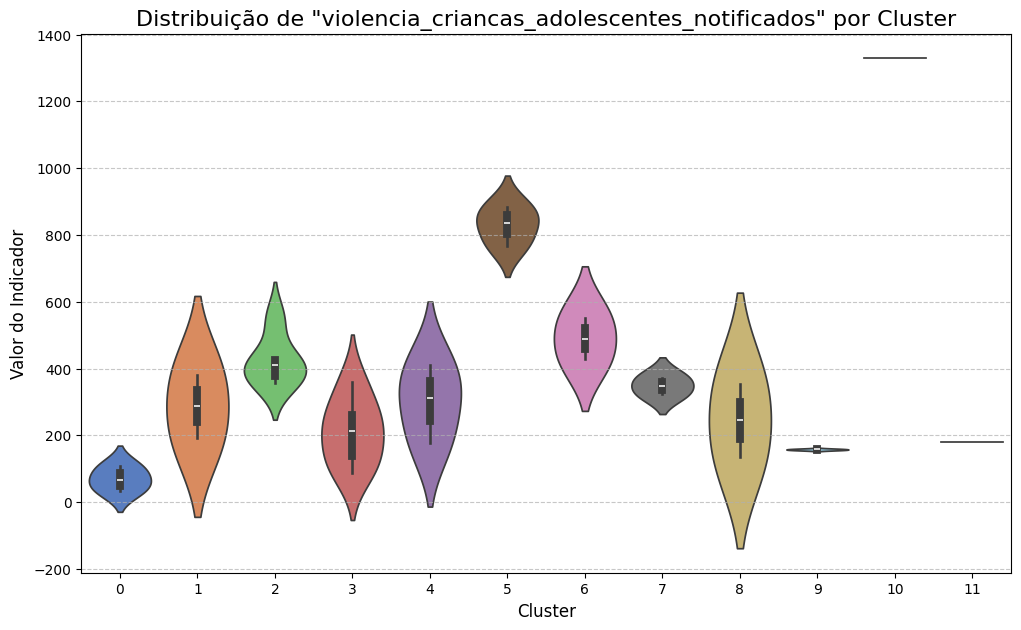

In [ ]:
# VISUALIZAÇÕES ADICIONAIS DOS CLUSTERS

# Gráfico 1: Gráfico de Barras do Tamanho dos Clusters

print("\n--- Contagem de Distritos por Cluster ---")
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df_cluster, palette='viridis')
plt.title('Número de Distritos em Cada Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Contagem de Distritos', fontsize=12)
plt.show()


# Gráfico 2: Gráfico de Dispersão Par a Par (Pair Plot)

print("\n--- Gráfico de Dispersão Par a Par (Pair Plot) ---")
colunas_pairplot = df_cluster.columns
sns.pairplot(df_cluster[colunas_pairplot], hue='cluster', palette='viridis')
plt.suptitle('Relação entre Pares de Indicadores por Cluster', y=1.02, fontsize=16)
plt.show()


# Gráfico 3: Gráfico de Violino para Distribuição Detalhada
print("\n--- Visualização dos Clusters com Gráficos de Violino ---")
for column in df_cluster.columns.drop('cluster'):
    plt.figure(figsize=(12, 7))
    sns.violinplot(x='cluster', y=column, data=df_cluster, palette='muted')
    plt.title(f'Distribuição de "{column}" por Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Valor do Indicador', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
